In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/01 10:30:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# EDA

In [15]:
df_holiday = pd.read_csv("data/holidays_events.csv")

In [16]:
df_holiday.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [17]:
df_holiday['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [3]:
df_sales = pd.read_csv("data/train.csv")

In [5]:
df_sales['store_nbr'].nunique()

54

In [16]:
df_oil = pd.read_csv("data/oil.csv")

In [18]:
import pandas as pd

# Ensure date column is datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Extract year–month
df_oil['year_month'] = df_oil['date'].dt.to_period('M')

# For each month, count how many non-null dcoilwtico values there are
monthly_non_nulls = (
    df_oil.groupby('year_month')['dcoilwtico']
          .apply(lambda x: x.notna().sum())
          .reset_index(name='non_null_count')
)

# Find months where there are *no* valid values
months_all_nan = monthly_non_nulls[monthly_non_nulls['non_null_count'] == 0]

print("Months with only NaN dcoilwtico values:")
print(months_all_nan)

Months with only NaN dcoilwtico values:
Empty DataFrame
Columns: [year_month, non_null_count]
Index: []


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure proper datetime conversion
df_sales["date"] = pd.to_datetime(df_sales["date"])

# Derive snapshot_month (first day of month)
df_sales["snapshot_month"] = df_sales["date"].dt.to_period("M").dt.to_timestamp()

# --- 1️⃣ Aggregate sales per store per month ---
monthly_sales = (
    df_sales.groupby(["store_nbr", "snapshot_month"])["sales"]
    .sum()
    .reset_index()
)

# --- 2️⃣ Keep only months where total sales > 0 ---
active_monthly_sales = monthly_sales[monthly_sales["sales"] > 0]

# --- 3️⃣ Compute first active month for each store ---
store_start_dates = (
    active_monthly_sales.groupby("store_nbr")["snapshot_month"]
    .min()
    .reset_index()
    .rename(columns={"snapshot_month": "first_active_month"})
    .sort_values("store_nbr")
)

print("✅ Number of stores:", store_start_dates.shape[0])
store_start_dates

✅ Number of stores: 54


,store_nbr,first_active_month
0,1,2013-01-01
1,2,2013-01-01
2,3,2013-01-01
3,4,2013-01-01
4,5,2013-01-01
5,6,2013-01-01
6,7,2013-01-01
7,8,2013-01-01
8,9,2013-01-01
9,10,2013-01-01


/tmp/ipykernel_64192/3656691435.py:11: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


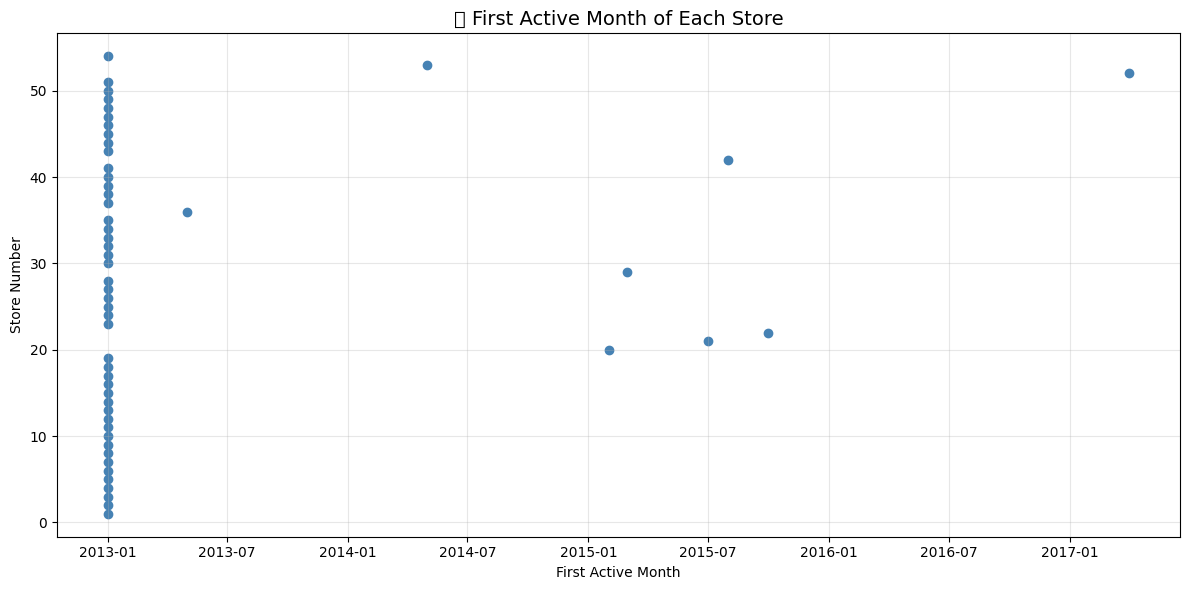

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(
    store_start_dates["first_active_month"],
    store_start_dates["store_nbr"],
    color="steelblue"
)
plt.title("🕐 First Active Month of Each Store", fontsize=14)
plt.xlabel("First Active Month")
plt.ylabel("Store Number")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure proper datetime and month granularity
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_sales["snapshot_month"] = df_sales["date"].dt.to_period("M").dt.to_timestamp()

# --- 1️⃣ Aggregate monthly sales across all stores ---
monthly_family_sales = (
    df_sales.groupby(["family", "snapshot_month"])["sales"]
    .sum()
    .reset_index()
)

# --- 2️⃣ Keep only months where total sales > 0 ---
active_family_sales = monthly_family_sales[monthly_family_sales["sales"] > 0]

# --- 3️⃣ Compute first active month for each family ---
family_start_dates = (
    active_family_sales.groupby("family")["snapshot_month"]
    .min()
    .reset_index()
    .rename(columns={"snapshot_month": "first_active_month"})
    .sort_values("first_active_month")
)

print(f"✅ Number of families: {family_start_dates.shape[0]}")
family_start_dates

✅ Number of families: 33


,family,first_active_month
0,AUTOMOTIVE,2013-01-01
29,PREPARED FOODS,2013-01-01
28,POULTRY,2013-01-01
25,PERSONAL CARE,2013-01-01
24,MEATS,2013-01-01
22,"LIQUOR,WINE,BEER",2013-01-01
21,LINGERIE,2013-01-01
20,LAWN AND GARDEN,2013-01-01
17,HOME APPLIANCES,2013-01-01
14,HARDWARE,2013-01-01


/tmp/ipykernel_64192/258152253.py:11: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


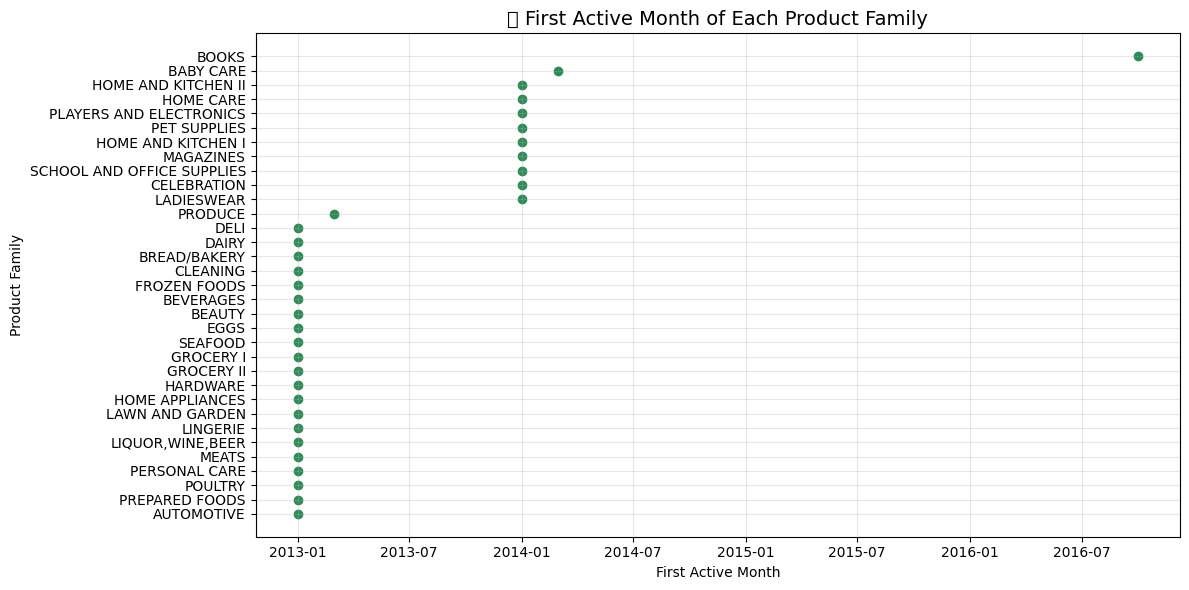

In [19]:
plt.figure(figsize=(12, 6))
plt.scatter(
    family_start_dates["first_active_month"],
    family_start_dates["family"],
    color="seagreen"
)
plt.title("🛍️ First Active Month of Each Product Family", fontsize=14)
plt.xlabel("First Active Month")
plt.ylabel("Product Family")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd

df_sales["date"] = pd.to_datetime(df_sales["date"])
df_sales["snapshot_month"] = df_sales["date"].dt.to_period("M").dt.to_timestamp()

# Filter only records with positive sales
active_sales = df_sales[df_sales["sales"] > 0]

# Compute first month of non-zero sales
store_family_start_dates = (
    active_sales.groupby(["store_nbr", "family"])["snapshot_month"]
    .min()
    .reset_index()
    .rename(columns={"snapshot_month": "first_active_month"})
)

# Filter for those that started after dataset's first month
late_starters = store_family_start_dates[
    store_family_start_dates["first_active_month"] > pd.Timestamp("2013-01-01")
].sort_values("first_active_month")

print(f"🕐 {len(late_starters)} store×family pairs started after 2013-01-01\n")
late_starters

🕐 805 store×family pairs started after 2013-01-01



,store_nbr,family,first_active_month
247,8,HOME APPLIANCES,2013-02-01
343,11,HOME APPLIANCES,2013-02-01
1491,47,HOME APPLIANCES,2013-02-01
727,23,LAWN AND GARDEN,2013-02-01
1523,48,HOME APPLIANCES,2013-02-01
...,...,...,...
1658,52,PERSONAL CARE,2017-04-01
1657,52,MEATS,2017-04-01
1636,52,BEAUTY,2017-04-01
1641,52,DAIRY,2017-04-01


/tmp/ipykernel_64192/4016562694.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


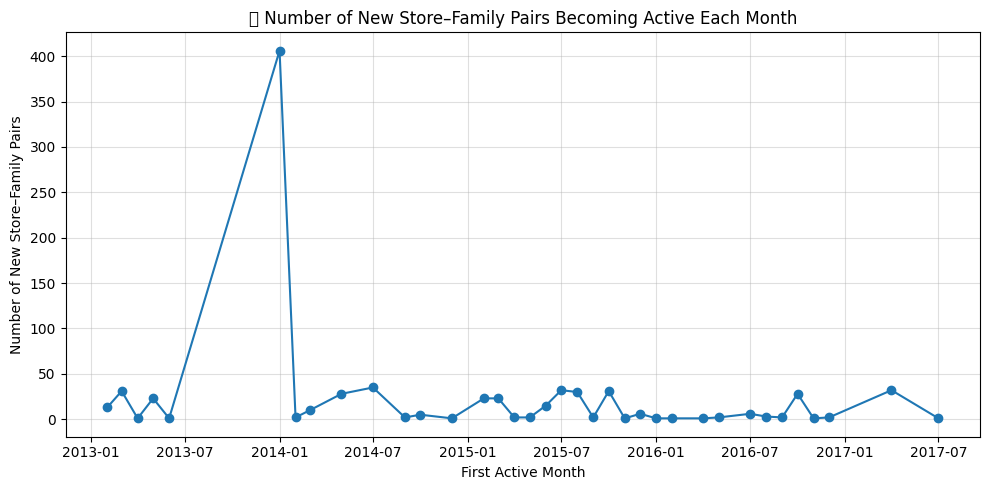

In [11]:
import matplotlib.pyplot as plt

# Count how many new store-family pairs started each month
monthly_starts = (
    late_starters.groupby("first_active_month")
    .size()
    .reset_index(name="num_new_pairs")
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_starts["first_active_month"], monthly_starts["num_new_pairs"], marker="o")
plt.title("📈 Number of New Store–Family Pairs Becoming Active Each Month")
plt.xlabel("First Active Month")
plt.ylabel("Number of New Store–Family Pairs")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

/tmp/ipykernel_64192/1203738032.py:9: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


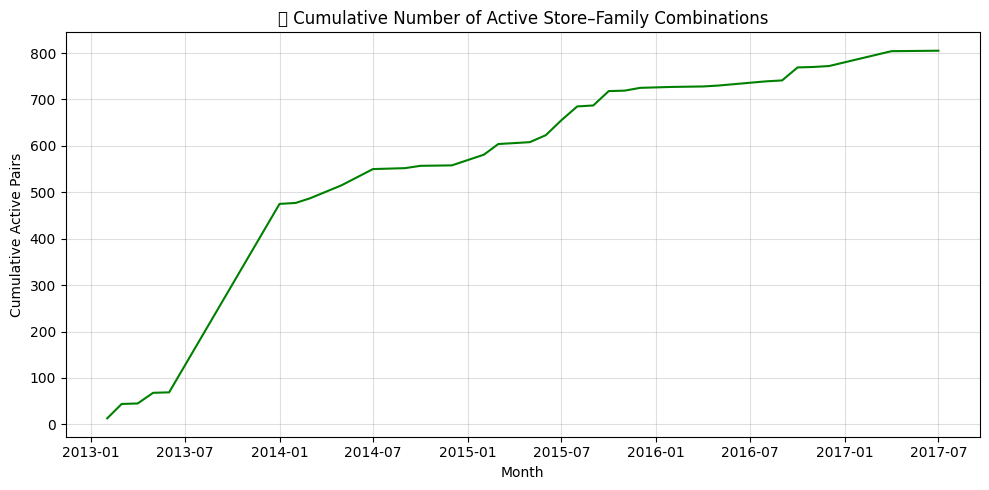

In [12]:
monthly_starts["cumulative_pairs"] = monthly_starts["num_new_pairs"].cumsum()

plt.figure(figsize=(10, 5))
plt.plot(monthly_starts["first_active_month"], monthly_starts["cumulative_pairs"], color="green")
plt.title("🧮 Cumulative Number of Active Store–Family Combinations")
plt.xlabel("Month")
plt.ylabel("Cumulative Active Pairs")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


In [20]:
df_sales.describe(include="all")

,id,date,store_nbr,family,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3000888,3.000888e+06,3.000888e+06
unique,NaN,1684,NaN,33,NaN,NaN
top,NaN,2013-01-01,NaN,AUTOMOTIVE,NaN,NaN
freq,NaN,1782,NaN,90936,NaN,NaN
mean,1.500444e+06,NaN,2.750000e+01,NaN,3.577757e+02,2.602770e+00
std,8.662819e+05,NaN,1.558579e+01,NaN,1.101998e+03,1.221888e+01
min,0.000000e+00,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,7.502218e+05,NaN,1.400000e+01,NaN,0.000000e+00,0.000000e+00
50%,1.500444e+06,NaN,2.750000e+01,NaN,1.100000e+01,0.000000e+00
75%,2.250665e+06,NaN,4.100000e+01,NaN,1.958473e+02,0.000000e+00


In [28]:
df_sales

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [12]:
df_transactions = pd.read_csv("data/transactions.csv")

In [13]:
df_transactions.describe(include='all')

,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
unique,1682,NaN,NaN
top,2017-07-15,NaN,NaN
freq,54,NaN,NaN
mean,NaN,26.939237,1694.602158
std,NaN,15.608204,963.286644
min,NaN,1.000000,5.000000
25%,NaN,13.000000,1046.000000
50%,NaN,27.000000,1393.000000
75%,NaN,40.000000,2079.000000


In [14]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [15]:
# Ensure date is datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Extract year–month
df_transactions['year_month'] = df_transactions['date'].dt.to_period('M')

# Count occurrences per store per month
store_month_counts = (
    df_transactions.groupby(['store_nbr', 'year_month'])['date']
    .nunique()
    .reset_index(name='n_unique_days')
)

# Find store–month pairs that appear more than once
duplicates = store_month_counts[store_month_counts['n_unique_days'] > 1]

print(f"{duplicates.shape[0]} store–month pairs have multiple entries")
print(duplicates.head())

2801 store–month pairs have multiple entries
   store_nbr year_month  n_unique_days
0          1    2013-01             30
1          1    2013-02             28
2          1    2013-03             31
3          1    2013-04             30
4          1    2013-05             31


In [16]:
duplicates

,store_nbr,year_month,n_unique_days
0,1,2013-01,30
1,1,2013-02,28
2,1,2013-03,31
3,1,2013-04,30
4,1,2013-05,31
...,...,...,...
2796,54,2017-04,30
2797,54,2017-05,31
2798,54,2017-06,30
2799,54,2017-07,31


In [25]:
df_oil = pd.read_csv("data/oil.csv")

In [27]:
df_oil.describe(include="all")

,date,dcoilwtico
count,1218,1175.000000
unique,1218,NaN
top,2013-01-01,NaN
freq,1,NaN
mean,NaN,67.714366
std,NaN,25.630476
min,NaN,26.190000
25%,NaN,46.405000
50%,NaN,53.190000
75%,NaN,95.660000


In [4]:
# -------------------------------------------------------------------------
# Specify dataset and snapshot month
# -------------------------------------------------------------------------
table_name = "daily_sales"        # e.g. "daily_sales", "oil_prices", "holiday_events"
snapshot_tag = "2013_01"          # corresponds to datamart/bronze/<table_name>/2013_01.parquet

# -------------------------------------------------------------------------
# Load parquet file
# -------------------------------------------------------------------------
path = f"datamart/bronze/{table_name}/{snapshot_tag}.parquet"
df = spark.read.parquet(path)

print(f"✅ Loaded {path}")
print(f"Total rows: {df.count():,}")

# -------------------------------------------------------------------------
# Convert to pandas for exploration
# -------------------------------------------------------------------------
pdf = df.toPandas()
print(f"Converted to pandas → shape: {pdf.shape}")

# Display first few rows
pdf.head()

✅ Loaded datamart/bronze/daily_sales/2013_01.parquet
Total rows: 55,242
Converted to pandas → shape: (55242, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
pdf

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
55237,55237,2013-01-31,9,POULTRY,335.215,0
55238,55238,2013-01-31,9,PREPARED FOODS,42.000,0
55239,55239,2013-01-31,9,PRODUCE,0.000,0
55240,55240,2013-01-31,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


In [5]:
# -------------------------------------------------------------------------
# Specify dataset and snapshot month
# -------------------------------------------------------------------------
table_name = "label_store"        # e.g. "daily_sales", "oil_prices", "holiday_events"
snapshot_tag = "2015_04_01"          # corresponds to datamart/bronze/<table_name>/2013_01.parquet

# -------------------------------------------------------------------------
# Load parquet file
# -------------------------------------------------------------------------
path = f"datamart/gold/{table_name}/{snapshot_tag}.parquet"
df = spark.read.parquet(path)

print(f"✅ Loaded {path}")
print(f"Total rows: {df.count():,}")

# -------------------------------------------------------------------------
# Convert to pandas for exploration
# -------------------------------------------------------------------------
pdf = df.toPandas()
print(f"Converted to pandas → shape: {pdf.shape}")

# Display first few rows
pdf.head()

✅ Loaded datamart/gold/label_store/2015_04_01.parquet
Total rows: 1,782
Converted to pandas → shape: (1782, 4)


,snapshot_date,store_nbr,family,label_next_month_sales
0,2015-04-01,26,SCHOOL AND OFFICE SUPPLIES,0.0
1,2015-04-01,27,PERSONAL CARE,7224.0
2,2015-04-01,3,DAIRY,69708.0
3,2015-04-01,34,PRODUCE,0.0
4,2015-04-01,43,BOOKS,0.0


In [8]:
pdf

,snapshot_date,store_nbr,family,label_next_month_sales
0,2015-04-01,26,SCHOOL AND OFFICE SUPPLIES,0.0
1,2015-04-01,27,PERSONAL CARE,7224.0
2,2015-04-01,3,DAIRY,69708.0
3,2015-04-01,34,PRODUCE,0.0
4,2015-04-01,43,BOOKS,0.0
...,...,...,...,...
1777,2015-04-01,29,HOME AND KITCHEN I,543.0
1778,2015-04-01,38,LAWN AND GARDEN,262.0
1779,2015-04-01,40,BOOKS,0.0
1780,2015-04-01,43,BABY CARE,0.0


In [9]:
pdf['label_next_month_sales'].describe()

count      1782.000000
mean       9949.701595
std       28536.320703
min           0.000000
25%           0.000000
50%         290.500000
75%        6353.454752
max      300173.000000
Name: label_next_month_sales, dtype: float64

In [24]:
# -------------------------------------------------------------------------
# Specify dataset and snapshot month
# -------------------------------------------------------------------------
table_name = "feature_store"        # e.g. "daily_sales", "oil_prices", "holiday_events"
snapshot_tag = "2014_02_01"          # corresponds to datamart/bronze/<table_name>/2013_01.parquet

# -------------------------------------------------------------------------
# Load parquet file
# -------------------------------------------------------------------------
path = f"datamart/gold/{table_name}/{snapshot_tag}.parquet"
df = spark.read.parquet(path)

print(f"✅ Loaded {path}")
print(f"Total rows: {df.count():,}")

# -------------------------------------------------------------------------
# Convert to pandas for exploration
# -------------------------------------------------------------------------
pdf = df.toPandas()
print(f"Converted to pandas → shape: {pdf.shape}")

# Display first few rows
pdf.head()

✅ Loaded datamart/gold/feature_store/2014_02_01.parquet
Total rows: 1,782
Converted to pandas → shape: (1782, 42)


,snapshot_date,store_nbr,family,sales,onpromotion_sum,onpromotion_avg,transactions,avg_dcoilwtico,num_holidays_total,num_transferred,...,SUM_sales_L3M,onpromotion_LM,AVG_onpromotion_L3M,SUM_onpromotion_L3M,transactions_LM,AVG_transactions_L3M,SUM_transactions_L3M,AVG_dcoilwtico_LM,AVG_dcoilwtico_L3M,SUM_dcoilwtico_L3M
0,2014-02-01,1,AUTOMOTIVE,85.0,0.0,0.0,43819.0,100.817368,NaN,NaN,...,217.0,0.0,0.0,0.0,43819.0,43819.000000,131457.0,100.817368,100.817368,302.452103
1,2014-02-01,1,BABY CARE,0.0,0.0,0.0,43819.0,100.817368,NaN,NaN,...,0.0,0.0,0.0,0.0,43819.0,43819.000000,131457.0,100.817368,100.817368,302.452103
2,2014-02-01,1,BEAUTY,55.0,0.0,0.0,43819.0,100.817368,NaN,NaN,...,175.0,0.0,0.0,0.0,43819.0,43819.000000,131457.0,100.817368,100.817368,302.452103
3,2014-02-01,1,BEVERAGES,25149.0,0.0,0.0,43819.0,100.817368,NaN,NaN,...,111752.0,0.0,0.0,0.0,43819.0,43819.000000,131457.0,100.817368,100.817368,302.452103
4,2014-02-01,1,BOOKS,0.0,0.0,0.0,43819.0,100.817368,NaN,NaN,...,0.0,0.0,0.0,0.0,43819.0,46217.666667,138653.0,100.817368,100.817368,302.452103


In [25]:
pdf[(pdf['family']=='PREPARED FOODS') & (pdf['store_nbr']=='11')]

,snapshot_date,store_nbr,family,sales,onpromotion_sum,onpromotion_avg,transactions,avg_dcoilwtico,num_holidays_total,num_transferred,...,SUM_sales_L3M,onpromotion_LM,AVG_onpromotion_L3M,SUM_onpromotion_L3M,transactions_LM,AVG_transactions_L3M,SUM_transactions_L3M,AVG_dcoilwtico_LM,AVG_dcoilwtico_L3M,SUM_dcoilwtico_L3M
95,2014-02-01,11,PREPARED FOODS,796.0,0.0,0.0,69299.0,100.817368,NaN,NaN,...,2434.0,0.0,0.0,0.0,69299.0,70670.333333,212011.0,100.817368,96.683885,290.051654


In [22]:
pdf.describe(include="all")

,snapshot_date,store_nbr,family,sales,onpromotion_sum,onpromotion_avg,transactions,avg_dcoilwtico,num_holidays_total,num_transferred,...,SUM_sales_L3M,onpromotion_LM,AVG_onpromotion_L3M,SUM_onpromotion_L3M,transactions_LM,AVG_transactions_L3M,SUM_transactions_L3M,AVG_dcoilwtico_LM,AVG_dcoilwtico_L3M,SUM_dcoilwtico_L3M
count,1782,1782,1782,1782.000000,1782.0,1782.0,1551.000000,1.782000e+03,1782.0,1782.0,...,1782.000000,1782.0,1782.0,1782.0,1551.000000,1551.000000,1551.000000,1.782000e+03,1782.000000,1782.000000
unique,1,54,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2014-01-01,1,AUTOMOTIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1782,33,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,10612.592988,0.0,0.0,50926.127660,9.461714e+01,1.0,0.0,...,26414.880553,0.0,0.0,0.0,50926.127660,51293.205674,153879.617021,9.461714e+01,94.618831,283.856493
std,NaN,NaN,NaN,29983.088503,0.0,0.0,26688.258321,1.421484e-14,0.0,0.0,...,75590.464687,0.0,0.0,0.0,26688.258321,27027.306985,81081.920954,1.421484e-14,0.053101,0.159303
min,NaN,NaN,NaN,0.000000,0.0,0.0,17244.000000,9.461714e+01,1.0,0.0,...,0.000000,0.0,0.0,0.0,17244.000000,17244.000000,51732.000000,9.461714e+01,94.617143,283.851429
25%,NaN,NaN,NaN,13.000000,0.0,0.0,31544.000000,9.461714e+01,1.0,0.0,...,28.000000,0.0,0.0,0.0,31544.000000,31544.000000,94632.000000,9.461714e+01,94.617143,283.851429
50%,NaN,NaN,NaN,365.000000,0.0,0.0,41979.000000,9.461714e+01,1.0,0.0,...,584.000000,0.0,0.0,0.0,41979.000000,41979.000000,125937.000000,9.461714e+01,94.617143,283.851429
75%,NaN,NaN,NaN,5926.000000,0.0,0.0,67151.000000,9.461714e+01,1.0,0.0,...,16250.884583,0.0,0.0,0.0,67151.000000,67151.000000,201453.000000,9.461714e+01,94.617143,283.851429


In [12]:
null_summary = pdf.isnull().sum()
null_summary = null_summary[null_summary > 0]
print(null_summary)

transactions                        231
num_holidays_total_NM              1782
num_transferred_NM                 1782
num_holidays_type_Event_NM         1782
num_holidays_type_Holiday_NM       1782
num_holidays_type_Transfer_NM      1782
num_holidays_type_Bridge_NM        1782
num_holidays_type_Additional_NM    1782
num_holidays_type_Work Day_NM      1782
num_holidays_locale_National_NM    1782
num_holidays_locale_Local_NM       1782
num_holidays_locale_Regional_NM    1782
transactions_LM                     231
AVG_transactions_L3M                231
SUM_transactions_L3M                231
dtype: int64


In [13]:
pdf.columns.to_list()

['snapshot_date',
 'store_nbr',
 'family',
 'sales',
 'onpromotion_sum',
 'onpromotion_avg',
 'transactions',
 'avg_dcoilwtico',
 'num_holidays_total',
 'num_transferred',
 'num_holidays_type_Event',
 'num_holidays_type_Holiday',
 'num_holidays_type_Transfer',
 'num_holidays_type_Bridge',
 'num_holidays_type_Additional',
 'num_holidays_type_Work Day',
 'num_holidays_locale_National',
 'num_holidays_locale_Local',
 'num_holidays_locale_Regional',
 'num_holidays_total_NM',
 'num_transferred_NM',
 'num_holidays_type_Event_NM',
 'num_holidays_type_Holiday_NM',
 'num_holidays_type_Transfer_NM',
 'num_holidays_type_Bridge_NM',
 'num_holidays_type_Additional_NM',
 'num_holidays_type_Work Day_NM',
 'num_holidays_locale_National_NM',
 'num_holidays_locale_Local_NM',
 'num_holidays_locale_Regional_NM',
 'sales_LM',
 'AVG_sales_L3M',
 'SUM_sales_L3M',
 'onpromotion_LM',
 'AVG_onpromotion_L3M',
 'SUM_onpromotion_L3M',
 'transactions_LM',
 'AVG_transactions_L3M',
 'SUM_transactions_L3M',
 'AVG_dcoi

In [7]:
import pandas as pd

pdf['date'] = pd.to_datetime(pdf['date'])
pdf['year_month'] = pdf['date'].dt.to_period('M')
promo_variability = (
    pdf.groupby(['store_nbr', 'family', 'year_month'])['onpromotion']
       .nunique()
       .reset_index(name='unique_promo_values')
)
# Compute the average (or mode) promotion flag per month
monthly_promo_status = (
    pdf.groupby(['store_nbr', 'family', 'year_month'])['onpromotion']
       .mean()
       .reset_index()
)

# Count how many unique promotion values across months for each combination
promo_change_across_months = (
    monthly_promo_status.groupby(['store_nbr', 'family'])['onpromotion']
        .nunique()
        .reset_index(name='n_unique_monthly_promo')
)

# Filter those that change across months
changing_promos = promo_change_across_months[promo_change_across_months['n_unique_monthly_promo'] > 1]
total_combos = promo_change_across_months.shape[0]
changing = changing_promos.shape[0]
print(f"{changing}/{total_combos} ({changing/total_combos:.1%}) store-family combos have variable promotion patterns across months.")

0/1782 (0.0%) store-family combos have variable promotion patterns across months.


In [8]:
promo_variability = (
    pdf.groupby(['store_nbr', 'family', 'year_month'])['onpromotion']
       .nunique()
       .reset_index(name='unique_promo_values')
)

# Any (store, family)–month where promo count changes daily?
promo_variability['is_constant'] = promo_variability['unique_promo_values'] == 1

print(promo_variability['is_constant'].value_counts())


is_constant
True    1782
Name: count, dtype: int64


In [ ]:
# -------------------------------------------------------------------------
# Specify dataset and snapshot month
# -------------------------------------------------------------------------
table_name = "holiday_events"        # e.g. "daily_sales", "oil_prices", "holiday_events"
snapshot_tag = "2013_01"          # corresponds to datamart/bronze/<table_name>/2013_01.parquet

# -------------------------------------------------------------------------
# Load parquet file
# -------------------------------------------------------------------------
path = f"datamart/bronze/{table_name}/{snapshot_tag}.parquet"
df = spark.read.parquet(path)

print(f"✅ Loaded {path}")
print(f"Total rows: {df.count():,}")

# -------------------------------------------------------------------------
# Convert to pandas for exploration
# -------------------------------------------------------------------------
pdf = df.toPandas()
print(f"Converted to pandas → shape: {pdf.shape}")

# Display first few rows
pdf.head()

In [8]:
# ---------------------------------------------------------------------
# 📂 Load the holiday features parquet
# ---------------------------------------------------------------------
# Load the actual directory
silver_path = "datamart/silver_reference/holiday_features.parquet/"
df_holiday = spark.read.parquet(silver_path)

# Convert to pandas for inspection
pdf_holiday = df_holiday.toPandas()

In [10]:
pdf_holiday.columns.to_list()

['snapshot_date',
 'num_holidays_total',
 'num_transferred',
 'num_holidays_type_Event',
 'num_holidays_type_Holiday',
 'num_holidays_type_Transfer',
 'num_holidays_type_Bridge',
 'num_holidays_type_Additional',
 'num_holidays_type_Work Day',
 'num_holidays_locale_National',
 'num_holidays_locale_Local',
 'num_holidays_locale_Regional',
 'num_holidays_total_NM',
 'num_transferred_NM',
 'num_holidays_type_Event_NM',
 'num_holidays_type_Holiday_NM',
 'num_holidays_type_Transfer_NM',
 'num_holidays_type_Bridge_NM',
 'num_holidays_type_Additional_NM',
 'num_holidays_type_Work Day_NM',
 'num_holidays_locale_National_NM',
 'num_holidays_locale_Local_NM',
 'num_holidays_locale_Regional_NM']

In [11]:
import pandas as pd
from pyspark.sql import functions as F

# Read from the same parquet again
df = spark.read.parquet("datamart/silver_reference/holiday_features.parquet/")
pdf = df.orderBy("snapshot_date").toPandas()

# Extract just the date parts for clarity
pdf["snapshot_date"] = pd.to_datetime(pdf["snapshot_date"])
pdf["snapshot_month"] = pdf["snapshot_date"].dt.to_period("M")

# Pick one easy feature to validate (e.g., num_holidays_total)
base = "num_holidays_total"
nm = f"{base}_NM"

# Create shifted version of the base feature for comparison
pdf["shifted_base"] = pdf[base].shift(-1)

# Compare this month’s `_NM` to next month’s `base`
comparison = pdf[[ "snapshot_month", base, nm, "shifted_base" ]].head(12)
display(comparison)

# Quick logical check
mismatch = (pdf[nm] != pdf["shifted_base"]).sum()
print(f"✅ Alignment check: {(len(pdf)-mismatch)} of {len(pdf)} months aligned correctly.")
if mismatch > 0:
    print(f"⚠️ {mismatch} mismatches found — possible edge case at the end of dataset (expected).")

,snapshot_month,num_holidays_total,num_holidays_total_NM,shifted_base
0,2012-03,1,4.0,4.0
1,2012-04,4,1.0,1.0
2,2012-05,1,4.0,4.0
3,2012-06,4,3.0,3.0
4,2012-07,3,4.0,4.0
5,2012-08,4,1.0,1.0
6,2012-09,1,3.0,3.0
7,2012-10,3,7.0,7.0
8,2012-11,7,13.0,13.0
9,2012-12,13,3.0,3.0


✅ Alignment check: 67 of 69 months aligned correctly.
⚠️ 2 mismatches found — possible edge case at the end of dataset (expected).


In [6]:
# ---------------------------------------------------------------------
# 📂 Define the path to the reference table you want to inspect
# ---------------------------------------------------------------------
path = "datamart/silver_reference/family_start_dates.parquet"  # or family_start_dates.parquet / store_start_dates.parquet / store_family_start_dates.parquet

# ---------------------------------------------------------------------
# 🔍 Load into Spark, then convert to Pandas
# ---------------------------------------------------------------------
df_ref = spark.read.parquet(path)
pdf_ref = df_ref.toPandas()

# ---------------------------------------------------------------------
# 🧠 Inspect in Pandas
# ---------------------------------------------------------------------
print(f"✅ Loaded {len(pdf_ref):,} rows from {path}")
pdf_ref

✅ Loaded 33 rows from datamart/silver_reference/family_start_dates.parquet


,family,first_active_month
0,AUTOMOTIVE,2013-01-01
1,BABY CARE,2014-03-01
2,BEAUTY,2013-01-01
3,BEVERAGES,2013-01-01
4,BOOKS,2016-10-01
5,BREAD/BAKERY,2013-01-01
6,CELEBRATION,2014-01-01
7,CLEANING,2013-01-01
8,DAIRY,2013-01-01
9,DELI,2013-01-01


In [4]:
# -------------------------------------------------------------------------
# Specify dataset and snapshot month
# -------------------------------------------------------------------------
table_name = "predictions"        # e.g. "daily_sales", "oil_prices", "holiday_events"
snapshot_tag = "2015-06-01"          # corresponds to datamart/bronze/<table_name>/2013_01.parquet

# -------------------------------------------------------------------------
# Load parquet file
# -------------------------------------------------------------------------
path = f"datamart/gold/{table_name}/{snapshot_tag}.parquet"
df = spark.read.parquet(path)

print(f"✅ Loaded {path}")
print(f"Total rows: {df.count():,}")

# -------------------------------------------------------------------------
# Convert to pandas for exploration
# -------------------------------------------------------------------------
pdf = df.toPandas()
print(f"Converted to pandas → shape: {pdf.shape}")

# Display first few rows
pdf.head()

✅ Loaded datamart/gold/predictions/2015-06-01.parquet
Total rows: 1,782
Converted to pandas → shape: (1782, 4)


,store_nbr,family,snapshot_date,predicted_sales
0,1,AUTOMOTIVE,2015-06-01,2300.023773
1,1,BABY CARE,2015-06-01,2300.023773
2,1,BEAUTY,2015-06-01,2300.023773
3,1,BEVERAGES,2015-06-01,36941.305791
4,1,BOOKS,2015-06-01,2300.023773


# Pipeline

## ETL

In [3]:
from utils.data_processing_holiday_reference import process_holiday_reference
# ---------------------------------------------------------------------
# ⚙️ Run the new holiday reference processing script
# ---------------------------------------------------------------------
process_holiday_reference(config_path="config/holiday_events_config.yaml")

# ---------------------------------------------------------------------
# 📂 Check output folders
# ---------------------------------------------------------------------
bronze_out = "datamart/bronze_reference/holiday_events_full.parquet"
silver_out = "datamart/silver_reference/holiday_features.parquet"

print("\n✅ Processing complete.")
print(f"Bronze reference saved to: {os.path.abspath(bronze_out)}")
print(f"Silver reference saved to: {os.path.abspath(silver_out)}")

2025-10-31 21:28:20,668 [INFO] 🔍 Using config file: /app/config/holiday_events_config.yaml
2025-10-31 21:28:21,043 [INFO] 📂 Reading /app/data/holidays_events.csv


2025-10-31 21:28:26,987 [INFO] ✅ Saved Bronze reference: /app/datamart/bronze_reference/holiday_events_full.parquet
2025-10-31 21:28:30,110 [INFO] ✅ Saved Silver reference: /app/datamart/silver_reference/holiday_features.parquet
2025-10-31 21:28:30,319 [INFO] 🎉 Holiday reference processing completed successfully.

✅ Processing complete.
Bronze reference saved to: /app/datamart/bronze_reference/holiday_events_full.parquet
Silver reference saved to: /app/datamart/silver_reference/holiday_features.parquet


In [3]:
from utils.data_processing_start_dates_reference import process_start_dates

process_start_dates(spark)

2025-11-01 03:09:10,774 [INFO] 🚀 Creating start-date reference tables from /app/data/train.csv


2025-11-01 03:09:13,114 [INFO] ✅ Loaded train.csv with 3,000,888 rows


2025-11-01 03:09:16,240 [INFO] 💾 Saved store_start_dates.parquet → /app/datamart/silver_reference/store_start_dates.parquet


2025-11-01 03:09:18,170 [INFO] 💾 Saved family_start_dates.parquet → /app/datamart/silver_reference/family_start_dates.parquet


2025-11-01 03:09:20,765 [INFO] 💾 Saved store_family_start_dates.parquet → /app/datamart/silver_reference/store_family_start_dates.parquet
2025-11-01 03:09:20,766 [INFO] 🎉 Start-date reference tables created successfully.


In [3]:
from utils.data_processing_bronze_table import process_bronze_month
# -------------------------------------------------------------------------
# Define monthly range for testing
# -------------------------------------------------------------------------
start_date = datetime(2013, 1, 1)   # first month
end_date = datetime(2017, 7, 1)     # last month to process
current_date = start_date

# -------------------------------------------------------------------------
# Loop month-by-month
# -------------------------------------------------------------------------
while current_date <= end_date:
    snapshot_str = current_date.strftime("%Y-%m-%d")
    print(f"\n=== 🗓️ Processing month starting {snapshot_str} ===")

    try:
        process_bronze_month(snapshot_date=snapshot_str, spark=spark)
    except Exception as e:
        print(f"⚠️ Failed to process {snapshot_str}: {e}")

    # Move forward by one month
    current_date += relativedelta(months=1)


=== 🗓️ Processing month starting 2013-01-01 ===
2025-10-31 19:53:17,710 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:53:17,717 [INFO] 🗓️ Processing Bronze layer for month: 2013-01-01 → 2013-01-31
2025-10-31 19:53:17,719 [INFO] 📂 Reading file: data/holidays_events.csv
2025-10-31 19:53:21,334 [INFO] 📅 holiday_events: 3 records for 2013_01_01


2025-10-31 19:53:23,016 [INFO] ✅ Saved Bronze file: datamart/bronze/holiday_events/2013_01_01.parquet (3 rows)
2025-10-31 19:53:23,017 [INFO] 📂 Reading file: data/train.csv


2025-10-31 19:53:25,363 [INFO] 📅 daily_sales: 55242 records for 2013_01_01


2025-10-31 19:53:30,366 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_01_01.parquet (55242 rows)
2025-10-31 19:53:30,366 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:53:30,952 [INFO] 📅 daily_transactions: 1381 records for 2013_01_01
2025-10-31 19:53:31,886 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_01_01.parquet (1381 rows)
2025-10-31 19:53:31,887 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:53:32,321 [INFO] 📅 oil_prices: 23 records for 2013_01_01
2025-10-31 19:53:30,456 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_01_01.parquet (23 rows)
2025-10-31 19:53:30,457 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-02-01 ===
2025-10-31 19:53:30,458 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:53:30,465 [INFO] 🗓️ Processing Bronze layer for month: 2013-02-01 → 2013-02-28
2025-10-31 19:53:30,466 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:53:33,852 [INFO] 📅 daily_sales: 49896 records for 2013_02_01


2025-10-31 19:53:38,856 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_02_01.parquet (49896 rows)
2025-10-31 19:53:38,856 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:53:39,348 [INFO] 📅 daily_transactions: 1288 records for 2013_02_01
2025-10-31 19:53:40,315 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_02_01.parquet (1288 rows)
2025-10-31 19:53:40,316 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:53:40,677 [INFO] 📅 oil_prices: 20 records for 2013_02_01
2025-10-31 19:53:41,588 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_02_01.parquet (20 rows)
2025-10-31 19:53:41,590 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-03-01 ===
2025-10-31 19:53:41,591 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:53:41,597 [INFO] 🗓️ Processing Bronze layer for month: 2013-03-01 → 2013-03-31
2025-10-31 19:53:41,598 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:53:44,852 [INFO] 📅 daily_sales: 55242 records for 2013_03_01


2025-10-31 19:53:49,684 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_03_01.parquet (55242 rows)
2025-10-31 19:53:49,685 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:53:50,147 [INFO] 📅 daily_transactions: 1426 records for 2013_03_01
2025-10-31 19:53:51,106 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_03_01.parquet (1426 rows)
2025-10-31 19:53:51,108 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:53:51,477 [INFO] 📅 oil_prices: 21 records for 2013_03_01
2025-10-31 19:53:52,407 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_03_01.parquet (21 rows)
2025-10-31 19:53:52,408 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-04-01 ===
2025-10-31 19:53:52,409 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:53:52,416 [INFO] 🗓️ Processing Bronze layer for month: 2013-04-01 → 2013-04-30
2025-10-31 19:53:52,417 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 80:===>                                                    (1 + 15) / 16]

2025-10-31 19:53:55,834 [INFO] 📅 daily_sales: 53460 records for 2013_04_01


2025-10-31 19:53:58,005 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_04_01.parquet (53460 rows)
2025-10-31 19:53:58,006 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:53:58,457 [INFO] 📅 daily_transactions: 1380 records for 2013_04_01
2025-10-31 19:53:59,416 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_04_01.parquet (1380 rows)
2025-10-31 19:53:59,417 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:53:59,700 [INFO] 📅 oil_prices: 22 records for 2013_04_01
2025-10-31 19:54:00,539 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_04_01.parquet (22 rows)
2025-10-31 19:54:00,540 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-05-01 ===
2025-10-31 19:54:00,540 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:54:00,547 [INFO] 🗓️ Processing Bronze layer for month: 2013-05-01 → 2013-05-31
2025-10-31 19:54:00,548 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 104:===>                                                   (1 + 15) / 16]

2025-10-31 19:54:04,171 [INFO] 📅 daily_sales: 55242 records for 2013_05_01


2025-10-31 19:54:08,989 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_05_01.parquet (55242 rows)
2025-10-31 19:54:08,990 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:54:09,427 [INFO] 📅 daily_transactions: 1449 records for 2013_05_01
2025-10-31 19:54:10,393 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_05_01.parquet (1449 rows)
2025-10-31 19:54:10,394 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:54:10,653 [INFO] 📅 oil_prices: 23 records for 2013_05_01
2025-10-31 19:54:11,487 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_05_01.parquet (23 rows)
2025-10-31 19:54:11,488 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-06-01 ===
2025-10-31 19:54:11,489 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:54:11,496 [INFO] 🗓️ Processing Bronze layer for month: 2013-06-01 → 2013-06-30
2025-10-31 19:54:11,497 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 128:===>                                                   (1 + 15) / 16]

2025-10-31 19:54:15,338 [INFO] 📅 daily_sales: 53460 records for 2013_06_01


2025-10-31 19:54:20,495 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_06_01.parquet (53460 rows)
2025-10-31 19:54:20,495 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:54:20,953 [INFO] 📅 daily_transactions: 1406 records for 2013_06_01
2025-10-31 19:54:21,849 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_06_01.parquet (1406 rows)
2025-10-31 19:54:21,850 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:54:22,130 [INFO] 📅 oil_prices: 20 records for 2013_06_01
2025-10-31 19:54:23,024 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_06_01.parquet (20 rows)
2025-10-31 19:54:23,025 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-07-01 ===
2025-10-31 19:54:23,026 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:54:23,035 [INFO] 🗓️ Processing Bronze layer for month: 2013-07-01 → 2013-07-31
2025-10-31 19:54:23,036 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 152:===>                                                   (1 + 15) / 16]

2025-10-31 19:54:26,771 [INFO] 📅 daily_sales: 55242 records for 2013_07_01


2025-10-31 19:54:29,108 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_07_01.parquet (55242 rows)
2025-10-31 19:54:29,109 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:54:29,572 [INFO] 📅 daily_transactions: 1434 records for 2013_07_01
2025-10-31 19:54:30,487 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_07_01.parquet (1434 rows)
2025-10-31 19:54:30,488 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:54:30,804 [INFO] 📅 oil_prices: 23 records for 2013_07_01
2025-10-31 19:54:31,639 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_07_01.parquet (23 rows)
2025-10-31 19:54:31,640 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-08-01 ===
2025-10-31 19:54:31,641 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:54:31,646 [INFO] 🗓️ Processing Bronze layer for month: 2013-08-01 → 2013-08-31
2025-10-31 19:54:31,647 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 176:===>                                                   (1 + 15) / 16]

2025-10-31 19:54:35,240 [INFO] 📅 daily_sales: 55242 records for 2013_08_01


2025-10-31 19:54:40,257 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_08_01.parquet (55242 rows)
2025-10-31 19:54:40,257 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:54:40,657 [INFO] 📅 daily_transactions: 1457 records for 2013_08_01
2025-10-31 19:54:41,619 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_08_01.parquet (1457 rows)
2025-10-31 19:54:41,620 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:54:41,869 [INFO] 📅 oil_prices: 22 records for 2013_08_01
2025-10-31 19:54:42,714 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_08_01.parquet (22 rows)
2025-10-31 19:54:42,715 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-09-01 ===
2025-10-31 19:54:42,716 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:54:42,725 [INFO] 🗓️ Processing Bronze layer for month: 2013-09-01 → 2013-09-30
2025-10-31 19:54:42,726 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:54:46,315 [INFO] 📅 daily_sales: 53460 records for 2013_09_01


2025-10-31 19:54:51,601 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_09_01.parquet (53460 rows)
2025-10-31 19:54:51,603 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:54:52,070 [INFO] 📅 daily_transactions: 1410 records for 2013_09_01
2025-10-31 19:54:53,074 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_09_01.parquet (1410 rows)
2025-10-31 19:54:53,076 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:54:53,368 [INFO] 📅 oil_prices: 21 records for 2013_09_01
2025-10-31 19:54:54,207 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_09_01.parquet (21 rows)
2025-10-31 19:54:54,209 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-10-01 ===
2025-10-31 19:54:54,210 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:54:54,217 [INFO] 🗓️ Processing Bronze layer for month: 2013-10-01 → 2013-10-31
2025-10-31 19:54:54,218 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 224:===>                                                   (1 + 15) / 16]

2025-10-31 19:54:55,008 [INFO] 📅 daily_sales: 55242 records for 2013_10_01


2025-10-31 19:55:00,452 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_10_01.parquet (55242 rows)
2025-10-31 19:55:00,454 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:55:00,966 [INFO] 📅 daily_transactions: 1457 records for 2013_10_01
2025-10-31 19:55:01,939 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_10_01.parquet (1457 rows)
2025-10-31 19:55:01,940 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:55:02,237 [INFO] 📅 oil_prices: 23 records for 2013_10_01
2025-10-31 19:55:03,125 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_10_01.parquet (23 rows)
2025-10-31 19:55:03,127 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-11-01 ===
2025-10-31 19:55:03,127 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:55:03,135 [INFO] 🗓️ Processing Bronze layer for month: 2013-11-01 → 2013-11-30
2025-10-31 19:55:03,136 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 248:===>                                                   (1 + 15) / 16]

2025-10-31 19:55:07,153 [INFO] 📅 daily_sales: 53460 records for 2013_11_01


2025-10-31 19:55:12,567 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_11_01.parquet (53460 rows)
2025-10-31 19:55:12,569 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:55:13,052 [INFO] 📅 daily_transactions: 1410 records for 2013_11_01
2025-10-31 19:55:14,054 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_11_01.parquet (1410 rows)
2025-10-31 19:55:14,056 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:55:14,359 [INFO] 📅 oil_prices: 21 records for 2013_11_01
2025-10-31 19:55:15,252 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_11_01.parquet (21 rows)
2025-10-31 19:55:15,253 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2013-12-01 ===
2025-10-31 19:55:15,254 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:55:15,260 [INFO] 🗓️ Processing Bronze layer for month: 2013-12-01 → 2013-12-31
2025-10-31 19:55:15,261 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 272:===>                                                   (1 + 15) / 16]

2025-10-31 19:55:18,610 [INFO] 📅 daily_sales: 53460 records for 2013_12_01


2025-10-31 19:55:20,588 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2013_12_01.parquet (53460 rows)
2025-10-31 19:55:20,590 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:55:20,996 [INFO] 📅 daily_transactions: 1410 records for 2013_12_01
2025-10-31 19:55:21,975 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2013_12_01.parquet (1410 rows)
2025-10-31 19:55:21,976 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:55:22,221 [INFO] 📅 oil_prices: 22 records for 2013_12_01
2025-10-31 19:55:23,151 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2013_12_01.parquet (22 rows)
2025-10-31 19:55:23,152 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-01-01 ===
2025-10-31 19:55:23,153 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:55:23,158 [INFO] 🗓️ Processing Bronze layer for month: 2014-01-01 → 2014-01-31
2025-10-31 19:55:23,159 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 296:===>                                                   (1 + 15) / 16]

2025-10-31 19:55:26,343 [INFO] 📅 daily_sales: 55242 records for 2014_01_01


2025-10-31 19:55:31,408 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_01_01.parquet (55242 rows)
2025-10-31 19:55:31,409 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:55:31,861 [INFO] 📅 daily_transactions: 1411 records for 2014_01_01
2025-10-31 19:55:32,837 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_01_01.parquet (1411 rows)
2025-10-31 19:55:32,838 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:55:33,141 [INFO] 📅 oil_prices: 23 records for 2014_01_01
2025-10-31 19:55:33,949 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_01_01.parquet (23 rows)
2025-10-31 19:55:33,950 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-02-01 ===
2025-10-31 19:55:33,951 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:55:33,958 [INFO] 🗓️ Processing Bronze layer for month: 2014-02-01 → 2014-02-28
2025-10-31 19:55:33,960 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:55:36,643 [INFO] 📅 daily_sales: 49896 records for 2014_02_01


2025-10-31 19:55:41,781 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_02_01.parquet (49896 rows)
2025-10-31 19:55:41,782 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:55:42,234 [INFO] 📅 daily_transactions: 1316 records for 2014_02_01
2025-10-31 19:55:43,096 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_02_01.parquet (1316 rows)
2025-10-31 19:55:43,097 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:55:43,407 [INFO] 📅 oil_prices: 20 records for 2014_02_01
2025-10-31 19:55:44,278 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_02_01.parquet (20 rows)
2025-10-31 19:55:44,279 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-03-01 ===
2025-10-31 19:55:44,279 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:55:44,288 [INFO] 🗓️ Processing Bronze layer for month: 2014-03-01 → 2014-03-31
2025-10-31 19:55:44,290 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:55:47,557 [INFO] 📅 daily_sales: 55242 records for 2014_03_01


2025-10-31 19:55:49,552 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_03_01.parquet (55242 rows)
2025-10-31 19:55:49,553 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:55:49,947 [INFO] 📅 daily_transactions: 1456 records for 2014_03_01
2025-10-31 19:55:50,799 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_03_01.parquet (1456 rows)
2025-10-31 19:55:50,801 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:55:51,048 [INFO] 📅 oil_prices: 21 records for 2014_03_01
2025-10-31 19:55:51,932 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_03_01.parquet (21 rows)
2025-10-31 19:55:51,934 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-04-01 ===
2025-10-31 19:55:51,935 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:55:51,942 [INFO] 🗓️ Processing Bronze layer for month: 2014-04-01 → 2014-04-30
2025-10-31 19:55:51,943 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 367:===>                                                   (1 + 15) / 16]

2025-10-31 19:55:55,363 [INFO] 📅 daily_sales: 53460 records for 2014_04_01


2025-10-31 19:56:00,475 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_04_01.parquet (53460 rows)
2025-10-31 19:56:00,477 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:00,908 [INFO] 📅 daily_transactions: 1393 records for 2014_04_01
2025-10-31 19:56:01,774 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_04_01.parquet (1393 rows)
2025-10-31 19:56:01,775 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:02,076 [INFO] 📅 oil_prices: 22 records for 2014_04_01
2025-10-31 19:56:02,910 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_04_01.parquet (22 rows)
2025-10-31 19:56:02,911 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-05-01 ===
2025-10-31 19:56:02,911 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:56:02,920 [INFO] 🗓️ Processing Bronze layer for month: 2014-05-01 → 2014-05-31
2025-10-31 19:56:02,921 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 391:===>                                                   (1 + 15) / 16]

2025-10-31 19:56:06,353 [INFO] 📅 daily_sales: 55242 records for 2014_05_01


2025-10-31 19:56:11,272 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_05_01.parquet (55242 rows)
2025-10-31 19:56:11,273 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:11,679 [INFO] 📅 daily_transactions: 1429 records for 2014_05_01
2025-10-31 19:56:12,559 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_05_01.parquet (1429 rows)
2025-10-31 19:56:12,561 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:12,809 [INFO] 📅 oil_prices: 22 records for 2014_05_01
2025-10-31 19:56:13,579 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_05_01.parquet (22 rows)
2025-10-31 19:56:13,580 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-06-01 ===
2025-10-31 19:56:13,581 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:56:13,590 [INFO] 🗓️ Processing Bronze layer for month: 2014-06-01 → 2014-06-30
2025-10-31 19:56:13,591 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:56:14,150 [INFO] 📅 daily_sales: 53460 records for 2014_06_01


2025-10-31 19:56:18,979 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_06_01.parquet (53460 rows)
2025-10-31 19:56:18,980 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:19,377 [INFO] 📅 daily_transactions: 1410 records for 2014_06_01
2025-10-31 19:56:20,292 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_06_01.parquet (1410 rows)
2025-10-31 19:56:20,293 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:20,537 [INFO] 📅 oil_prices: 21 records for 2014_06_01
2025-10-31 19:56:21,328 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_06_01.parquet (21 rows)
2025-10-31 19:56:21,329 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-07-01 ===
2025-10-31 19:56:21,329 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:56:21,336 [INFO] 🗓️ Processing Bronze layer for month: 2014-07-01 → 2014-07-31
2025-10-31 19:56:21,338 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 439:===>                                                   (1 + 15) / 16]

2025-10-31 19:56:24,670 [INFO] 📅 daily_sales: 55242 records for 2014_07_01


2025-10-31 19:56:29,398 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_07_01.parquet (55242 rows)
2025-10-31 19:56:29,399 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:29,833 [INFO] 📅 daily_transactions: 1465 records for 2014_07_01
2025-10-31 19:56:30,681 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_07_01.parquet (1465 rows)
2025-10-31 19:56:30,682 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:30,894 [INFO] 📅 oil_prices: 23 records for 2014_07_01
2025-10-31 19:56:31,657 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_07_01.parquet (23 rows)
2025-10-31 19:56:31,658 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-08-01 ===
2025-10-31 19:56:31,659 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:56:31,664 [INFO] 🗓️ Processing Bronze layer for month: 2014-08-01 → 2014-08-31
2025-10-31 19:56:31,666 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:56:34,969 [INFO] 📅 daily_sales: 55242 records for 2014_08_01


2025-10-31 19:56:39,905 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_08_01.parquet (55242 rows)
2025-10-31 19:56:39,906 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:40,348 [INFO] 📅 daily_transactions: 1460 records for 2014_08_01
2025-10-31 19:56:41,213 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_08_01.parquet (1460 rows)
2025-10-31 19:56:41,214 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:41,452 [INFO] 📅 oil_prices: 21 records for 2014_08_01
2025-10-31 19:56:42,256 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_08_01.parquet (21 rows)
2025-10-31 19:56:42,257 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-09-01 ===
2025-10-31 19:56:42,258 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:56:42,263 [INFO] 🗓️ Processing Bronze layer for month: 2014-09-01 → 2014-09-30
2025-10-31 19:56:42,264 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:56:47,653 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_09_01.parquet (53460 rows)
2025-10-31 19:56:47,653 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:48,047 [INFO] 📅 daily_transactions: 1430 records for 2014_09_01
2025-10-31 19:56:48,919 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_09_01.parquet (1430 rows)
2025-10-31 19:56:48,920 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:49,194 [INFO] 📅 oil_prices: 22 records for 2014_09_01
2025-10-31 19:56:49,970 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_09_01.parquet (22 rows)
2025-10-31 19:56:49,971 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-10-01 ===
2025-10-31 19:56:49,972 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:56:49,978 [INFO] 🗓️ Processing Bronze layer for month: 2014-10-01 → 2014-10-31
2025-10-31 19:56:49,980 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 511:===>                                                   (1 + 15) / 16]

2025-10-31 19:56:53,151 [INFO] 📅 daily_sales: 55242 records for 2014_10_01


2025-10-31 19:56:57,988 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_10_01.parquet (55242 rows)
2025-10-31 19:56:57,989 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:56:58,447 [INFO] 📅 daily_transactions: 1488 records for 2014_10_01
2025-10-31 19:56:59,302 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_10_01.parquet (1488 rows)
2025-10-31 19:56:59,303 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:56:59,540 [INFO] 📅 oil_prices: 23 records for 2014_10_01
2025-10-31 19:57:00,434 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_10_01.parquet (23 rows)
2025-10-31 19:57:00,435 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-11-01 ===
2025-10-31 19:57:00,436 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:00,442 [INFO] 🗓️ Processing Bronze layer for month: 2014-11-01 → 2014-11-30
2025-10-31 19:57:00,443 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 535:===>                                                   (1 + 15) / 16]

2025-10-31 19:57:03,948 [INFO] 📅 daily_sales: 53460 records for 2014_11_01


2025-10-31 19:57:08,883 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_11_01.parquet (53460 rows)
2025-10-31 19:57:08,884 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:57:09,350 [INFO] 📅 daily_transactions: 1440 records for 2014_11_01
2025-10-31 19:57:10,222 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_11_01.parquet (1440 rows)
2025-10-31 19:57:10,223 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:57:10,463 [INFO] 📅 oil_prices: 20 records for 2014_11_01
2025-10-31 19:57:08,775 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_11_01.parquet (20 rows)
2025-10-31 19:57:08,776 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2014-12-01 ===
2025-10-31 19:57:08,777 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:08,784 [INFO] 🗓️ Processing Bronze layer for month: 2014-12-01 → 2014-12-31
2025-10-31 19:57:08,786 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:57:12,134 [INFO] 📅 daily_sales: 53460 records for 2014_12_01


2025-10-31 19:57:16,904 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2014_12_01.parquet (53460 rows)
2025-10-31 19:57:16,906 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:57:17,342 [INFO] 📅 daily_transactions: 1440 records for 2014_12_01
2025-10-31 19:57:18,192 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2014_12_01.parquet (1440 rows)
2025-10-31 19:57:18,193 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:57:18,429 [INFO] 📅 oil_prices: 23 records for 2014_12_01
2025-10-31 19:57:19,196 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2014_12_01.parquet (23 rows)
2025-10-31 19:57:19,197 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-01-01 ===
2025-10-31 19:57:19,198 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:19,204 [INFO] 🗓️ Processing Bronze layer for month: 2015-01-01 → 2015-01-31
2025-10-31 19:57:19,205 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 583:===>                                                   (1 + 15) / 16]

2025-10-31 19:57:22,448 [INFO] 📅 daily_sales: 55242 records for 2015_01_01


2025-10-31 19:57:27,287 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_01_01.parquet (55242 rows)
2025-10-31 19:57:27,288 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:57:27,692 [INFO] 📅 daily_transactions: 1441 records for 2015_01_01
2025-10-31 19:57:28,624 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_01_01.parquet (1441 rows)
2025-10-31 19:57:28,625 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:57:28,878 [INFO] 📅 oil_prices: 22 records for 2015_01_01
2025-10-31 19:57:29,672 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_01_01.parquet (22 rows)
2025-10-31 19:57:29,673 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-02-01 ===
2025-10-31 19:57:29,674 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:29,679 [INFO] 🗓️ Processing Bronze layer for month: 2015-02-01 → 2015-02-28
2025-10-31 19:57:29,681 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:57:32,864 [INFO] 📅 daily_sales: 49896 records for 2015_02_01


2025-10-31 19:57:37,806 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_02_01.parquet (49896 rows)
2025-10-31 19:57:37,807 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:57:38,234 [INFO] 📅 daily_transactions: 1360 records for 2015_02_01
2025-10-31 19:57:36,440 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_02_01.parquet (1360 rows)
2025-10-31 19:57:36,441 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:57:36,700 [INFO] 📅 oil_prices: 20 records for 2015_02_01
2025-10-31 19:57:37,486 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_02_01.parquet (20 rows)
2025-10-31 19:57:37,487 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-03-01 ===
2025-10-31 19:57:37,488 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:37,496 [INFO] 🗓️ Processing Bronze layer for month: 2015-03-01 → 2015-03-31
2025-10-31 19:57:37,497 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:57:40,812 [INFO] 📅 daily_sales: 55242 records for 2015_03_01


2025-10-31 19:57:45,696 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_03_01.parquet (55242 rows)
2025-10-31 19:57:45,697 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:57:46,105 [INFO] 📅 daily_transactions: 1529 records for 2015_03_01
2025-10-31 19:57:46,962 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_03_01.parquet (1529 rows)
2025-10-31 19:57:46,963 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:57:47,245 [INFO] 📅 oil_prices: 22 records for 2015_03_01
2025-10-31 19:57:48,035 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_03_01.parquet (22 rows)
2025-10-31 19:57:48,036 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-04-01 ===
2025-10-31 19:57:48,037 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:48,043 [INFO] 🗓️ Processing Bronze layer for month: 2015-04-01 → 2015-04-30
2025-10-31 19:57:48,045 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:57:51,170 [INFO] 📅 daily_sales: 53460 records for 2015_04_01


2025-10-31 19:57:56,482 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_04_01.parquet (53460 rows)
2025-10-31 19:57:56,483 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:57:56,907 [INFO] 📅 daily_transactions: 1470 records for 2015_04_01
2025-10-31 19:57:57,765 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_04_01.parquet (1470 rows)
2025-10-31 19:57:57,766 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:57:58,000 [INFO] 📅 oil_prices: 22 records for 2015_04_01
2025-10-31 19:57:58,825 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_04_01.parquet (22 rows)
2025-10-31 19:57:58,826 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-05-01 ===
2025-10-31 19:57:58,827 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:57:58,835 [INFO] 🗓️ Processing Bronze layer for month: 2015-05-01 → 2015-05-31
2025-10-31 19:57:58,836 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 679:===>                                                   (1 + 15) / 16]

2025-10-31 19:58:02,201 [INFO] 📅 daily_sales: 55242 records for 2015_05_01


2025-10-31 19:58:04,352 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_05_01.parquet (55242 rows)
2025-10-31 19:58:04,353 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:58:04,751 [INFO] 📅 daily_transactions: 1522 records for 2015_05_01
2025-10-31 19:58:05,708 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_05_01.parquet (1522 rows)
2025-10-31 19:58:05,709 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:58:05,962 [INFO] 📅 oil_prices: 21 records for 2015_05_01
2025-10-31 19:58:06,804 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_05_01.parquet (21 rows)
2025-10-31 19:58:06,805 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-06-01 ===
2025-10-31 19:58:06,806 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:58:06,813 [INFO] 🗓️ Processing Bronze layer for month: 2015-06-01 → 2015-06-30
2025-10-31 19:58:06,814 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 703:===>                                                   (1 + 15) / 16]

2025-10-31 19:58:10,328 [INFO] 📅 daily_sales: 53460 records for 2015_06_01


2025-10-31 19:58:15,159 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_06_01.parquet (53460 rows)
2025-10-31 19:58:15,159 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:58:15,568 [INFO] 📅 daily_transactions: 1500 records for 2015_06_01
2025-10-31 19:58:16,406 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_06_01.parquet (1500 rows)
2025-10-31 19:58:16,408 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:58:16,673 [INFO] 📅 oil_prices: 22 records for 2015_06_01
2025-10-31 19:58:17,474 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_06_01.parquet (22 rows)
2025-10-31 19:58:17,475 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-07-01 ===
2025-10-31 19:58:17,476 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:58:17,481 [INFO] 🗓️ Processing Bronze layer for month: 2015-07-01 → 2015-07-31
2025-10-31 19:58:17,483 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 727:===>                                                   (1 + 15) / 16]

2025-10-31 19:58:20,762 [INFO] 📅 daily_sales: 55242 records for 2015_07_01


2025-10-31 19:58:25,560 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_07_01.parquet (55242 rows)
2025-10-31 19:58:25,561 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:58:26,019 [INFO] 📅 daily_transactions: 1557 records for 2015_07_01
2025-10-31 19:58:26,852 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_07_01.parquet (1557 rows)
2025-10-31 19:58:26,852 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:58:27,067 [INFO] 📅 oil_prices: 23 records for 2015_07_01
2025-10-31 19:58:27,824 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_07_01.parquet (23 rows)
2025-10-31 19:58:27,824 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-08-01 ===
2025-10-31 19:58:27,825 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:58:27,831 [INFO] 🗓️ Processing Bronze layer for month: 2015-08-01 → 2015-08-31
2025-10-31 19:58:27,832 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 751:===>                                                   (1 + 15) / 16]

2025-10-31 19:58:31,110 [INFO] 📅 daily_sales: 55242 records for 2015_08_01


2025-10-31 19:58:33,281 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_08_01.parquet (55242 rows)
2025-10-31 19:58:33,282 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:58:33,691 [INFO] 📅 daily_transactions: 1592 records for 2015_08_01
2025-10-31 19:58:34,566 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_08_01.parquet (1592 rows)
2025-10-31 19:58:34,567 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:58:34,822 [INFO] 📅 oil_prices: 21 records for 2015_08_01
2025-10-31 19:58:35,573 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_08_01.parquet (21 rows)
2025-10-31 19:58:35,574 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-09-01 ===
2025-10-31 19:58:35,575 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:58:35,582 [INFO] 🗓️ Processing Bronze layer for month: 2015-09-01 → 2015-09-30
2025-10-31 19:58:35,583 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 775:===>                                                   (1 + 15) / 16]

2025-10-31 19:58:38,758 [INFO] 📅 daily_sales: 53460 records for 2015_09_01


2025-10-31 19:58:43,406 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_09_01.parquet (53460 rows)
2025-10-31 19:58:43,407 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:58:43,810 [INFO] 📅 daily_transactions: 1560 records for 2015_09_01
2025-10-31 19:58:44,658 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_09_01.parquet (1560 rows)
2025-10-31 19:58:44,659 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:58:44,910 [INFO] 📅 oil_prices: 22 records for 2015_09_01
2025-10-31 19:58:45,694 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_09_01.parquet (22 rows)
2025-10-31 19:58:45,695 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-10-01 ===
2025-10-31 19:58:45,696 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:58:45,702 [INFO] 🗓️ Processing Bronze layer for month: 2015-10-01 → 2015-10-31
2025-10-31 19:58:45,704 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:58:48,923 [INFO] 📅 daily_sales: 55242 records for 2015_10_01


2025-10-31 19:58:53,784 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_10_01.parquet (55242 rows)
2025-10-31 19:58:53,785 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:58:54,210 [INFO] 📅 daily_transactions: 1635 records for 2015_10_01
2025-10-31 19:58:55,063 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_10_01.parquet (1635 rows)
2025-10-31 19:58:55,064 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:58:55,289 [INFO] 📅 oil_prices: 22 records for 2015_10_01
2025-10-31 19:58:56,113 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_10_01.parquet (22 rows)
2025-10-31 19:58:56,114 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-11-01 ===
2025-10-31 19:58:56,115 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:58:56,121 [INFO] 🗓️ Processing Bronze layer for month: 2015-11-01 → 2015-11-30
2025-10-31 19:58:56,122 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:58:59,338 [INFO] 📅 daily_sales: 53460 records for 2015_11_01


2025-10-31 19:59:01,373 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_11_01.parquet (53460 rows)
2025-10-31 19:59:01,374 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:01,852 [INFO] 📅 daily_transactions: 1590 records for 2015_11_01
2025-10-31 19:59:02,776 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_11_01.parquet (1590 rows)
2025-10-31 19:59:02,777 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:59:02,991 [INFO] 📅 oil_prices: 21 records for 2015_11_01
2025-10-31 19:59:03,736 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_11_01.parquet (21 rows)
2025-10-31 19:59:03,736 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2015-12-01 ===
2025-10-31 19:59:03,737 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:59:03,745 [INFO] 🗓️ Processing Bronze layer for month: 2015-12-01 → 2015-12-31
2025-10-31 19:59:03,746 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 847:===>                                                   (1 + 15) / 16]

2025-10-31 19:59:06,887 [INFO] 📅 daily_sales: 53460 records for 2015_12_01


2025-10-31 19:59:11,739 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2015_12_01.parquet (53460 rows)
2025-10-31 19:59:11,740 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:12,147 [INFO] 📅 daily_transactions: 1590 records for 2015_12_01
2025-10-31 19:59:13,160 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2015_12_01.parquet (1590 rows)
2025-10-31 19:59:13,162 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:59:13,427 [INFO] 📅 oil_prices: 23 records for 2015_12_01
2025-10-31 19:59:14,291 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2015_12_01.parquet (23 rows)
2025-10-31 19:59:14,292 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-01-01 ===
2025-10-31 19:59:14,293 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:59:14,300 [INFO] 🗓️ Processing Bronze layer for month: 2016-01-01 → 2016-01-31
2025-10-31 19:59:14,301 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 871:===>                                                   (1 + 15) / 16]

2025-10-31 19:59:17,751 [INFO] 📅 daily_sales: 55242 records for 2016_01_01


2025-10-31 19:59:22,715 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_01_01.parquet (55242 rows)
2025-10-31 19:59:22,716 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:23,145 [INFO] 📅 daily_transactions: 1481 records for 2016_01_01
2025-10-31 19:59:24,064 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_01_01.parquet (1481 rows)
2025-10-31 19:59:24,065 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:59:24,282 [INFO] 📅 oil_prices: 21 records for 2016_01_01
2025-10-31 19:59:25,059 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_01_01.parquet (21 rows)
2025-10-31 19:59:25,060 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-02-01 ===
2025-10-31 19:59:25,061 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:59:25,066 [INFO] 🗓️ Processing Bronze layer for month: 2016-02-01 → 2016-02-29
2025-10-31 19:59:25,067 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 19:59:25,568 [INFO] 📅 daily_sales: 51678 records for 2016_02_01


2025-10-31 19:59:30,417 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_02_01.parquet (51678 rows)
2025-10-31 19:59:30,418 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:30,796 [INFO] 📅 daily_transactions: 1537 records for 2016_02_01
2025-10-31 19:59:31,627 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_02_01.parquet (1537 rows)
2025-10-31 19:59:31,628 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:59:31,882 [INFO] 📅 oil_prices: 21 records for 2016_02_01
2025-10-31 19:59:32,747 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_02_01.parquet (21 rows)
2025-10-31 19:59:32,748 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-03-01 ===
2025-10-31 19:59:32,749 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:59:32,757 [INFO] 🗓️ Processing Bronze layer for month: 2016-03-01 → 2016-03-31
2025-10-31 19:59:32,758 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 919:===================================================>   (15 + 1) / 16]

2025-10-31 19:59:35,941 [INFO] 📅 daily_sales: 55242 records for 2016_03_01


2025-10-31 19:59:40,744 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_03_01.parquet (55242 rows)
2025-10-31 19:59:40,744 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:41,131 [INFO] 📅 daily_transactions: 1641 records for 2016_03_01
2025-10-31 19:59:42,029 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_03_01.parquet (1641 rows)
2025-10-31 19:59:42,030 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:59:42,275 [INFO] 📅 oil_prices: 23 records for 2016_03_01
2025-10-31 19:59:43,104 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_03_01.parquet (23 rows)
2025-10-31 19:59:43,105 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-04-01 ===
2025-10-31 19:59:43,106 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:59:43,114 [INFO] 🗓️ Processing Bronze layer for month: 2016-04-01 → 2016-04-30
2025-10-31 19:59:43,115 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 943:============================>                           (8 + 8) / 16]

2025-10-31 19:59:46,531 [INFO] 📅 daily_sales: 53460 records for 2016_04_01


2025-10-31 19:59:51,725 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_04_01.parquet (53460 rows)
2025-10-31 19:59:51,726 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:52,124 [INFO] 📅 daily_transactions: 1590 records for 2016_04_01
2025-10-31 19:59:53,060 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_04_01.parquet (1590 rows)
2025-10-31 19:59:53,061 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 19:59:53,302 [INFO] 📅 oil_prices: 21 records for 2016_04_01
2025-10-31 19:59:54,113 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_04_01.parquet (21 rows)
2025-10-31 19:59:54,114 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-05-01 ===
2025-10-31 19:59:54,115 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 19:59:54,121 [INFO] 🗓️ Processing Bronze layer for month: 2016-05-01 → 2016-05-31
2025-10-31 19:59:54,122 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 967:===>                                                   (1 + 15) / 16]

2025-10-31 19:59:54,587 [INFO] 📅 daily_sales: 55242 records for 2016_05_01


2025-10-31 19:59:59,356 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_05_01.parquet (55242 rows)
2025-10-31 19:59:59,358 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 19:59:59,776 [INFO] 📅 daily_transactions: 1643 records for 2016_05_01
2025-10-31 20:00:00,786 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_05_01.parquet (1643 rows)
2025-10-31 20:00:00,787 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:01,009 [INFO] 📅 oil_prices: 22 records for 2016_05_01
2025-10-31 20:00:01,769 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_05_01.parquet (22 rows)
2025-10-31 20:00:01,770 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-06-01 ===
2025-10-31 20:00:01,771 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:01,776 [INFO] 🗓️ Processing Bronze layer for month: 2016-06-01 → 2016-06-30
2025-10-31 20:00:01,777 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 991:===>                                                   (1 + 15) / 16]

2025-10-31 20:00:04,985 [INFO] 📅 daily_sales: 53460 records for 2016_06_01


2025-10-31 20:00:09,679 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_06_01.parquet (53460 rows)
2025-10-31 20:00:09,680 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:00:10,153 [INFO] 📅 daily_transactions: 1590 records for 2016_06_01
2025-10-31 20:00:11,034 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_06_01.parquet (1590 rows)
2025-10-31 20:00:11,035 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:11,252 [INFO] 📅 oil_prices: 22 records for 2016_06_01
2025-10-31 20:00:12,020 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_06_01.parquet (22 rows)
2025-10-31 20:00:12,022 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-07-01 ===
2025-10-31 20:00:12,023 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:12,030 [INFO] 🗓️ Processing Bronze layer for month: 2016-07-01 → 2016-07-31
2025-10-31 20:00:12,032 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:00:15,307 [INFO] 📅 daily_sales: 55242 records for 2016_07_01


2025-10-31 20:00:20,013 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_07_01.parquet (55242 rows)
2025-10-31 20:00:20,014 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:00:20,431 [INFO] 📅 daily_transactions: 1643 records for 2016_07_01
2025-10-31 20:00:21,324 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_07_01.parquet (1643 rows)
2025-10-31 20:00:21,325 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:21,567 [INFO] 📅 oil_prices: 21 records for 2016_07_01
2025-10-31 20:00:19,756 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_07_01.parquet (21 rows)
2025-10-31 20:00:19,757 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-08-01 ===
2025-10-31 20:00:19,758 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:19,767 [INFO] 🗓️ Processing Bronze layer for month: 2016-08-01 → 2016-08-31
2025-10-31 20:00:19,768 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 1039:===>                                                  (1 + 15) / 16]

2025-10-31 20:00:23,389 [INFO] 📅 daily_sales: 55242 records for 2016_08_01


2025-10-31 20:00:29,152 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_08_01.parquet (55242 rows)
2025-10-31 20:00:29,153 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:00:29,627 [INFO] 📅 daily_transactions: 1616 records for 2016_08_01
2025-10-31 20:00:30,505 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_08_01.parquet (1616 rows)
2025-10-31 20:00:30,506 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:30,760 [INFO] 📅 oil_prices: 23 records for 2016_08_01
2025-10-31 20:00:31,540 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_08_01.parquet (23 rows)
2025-10-31 20:00:31,541 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-09-01 ===
2025-10-31 20:00:31,541 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:31,547 [INFO] 🗓️ Processing Bronze layer for month: 2016-09-01 → 2016-09-30
2025-10-31 20:00:31,550 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 1063:===>                                                  (1 + 15) / 16]

2025-10-31 20:00:35,045 [INFO] 📅 daily_sales: 53460 records for 2016_09_01


2025-10-31 20:00:39,777 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_09_01.parquet (53460 rows)
2025-10-31 20:00:39,778 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:00:40,168 [INFO] 📅 daily_transactions: 1528 records for 2016_09_01
2025-10-31 20:00:41,000 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_09_01.parquet (1528 rows)
2025-10-31 20:00:41,000 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:41,226 [INFO] 📅 oil_prices: 22 records for 2016_09_01
2025-10-31 20:00:42,010 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_09_01.parquet (22 rows)
2025-10-31 20:00:42,011 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-10-01 ===
2025-10-31 20:00:42,012 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:42,017 [INFO] 🗓️ Processing Bronze layer for month: 2016-10-01 → 2016-10-31
2025-10-31 20:00:42,018 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:00:45,187 [INFO] 📅 daily_sales: 55242 records for 2016_10_01


2025-10-31 20:00:47,264 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_10_01.parquet (55242 rows)
2025-10-31 20:00:47,265 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:00:47,648 [INFO] 📅 daily_transactions: 1586 records for 2016_10_01
2025-10-31 20:00:48,502 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_10_01.parquet (1586 rows)
2025-10-31 20:00:48,502 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:48,718 [INFO] 📅 oil_prices: 21 records for 2016_10_01
2025-10-31 20:00:49,485 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_10_01.parquet (21 rows)
2025-10-31 20:00:49,486 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-11-01 ===
2025-10-31 20:00:49,487 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:49,493 [INFO] 🗓️ Processing Bronze layer for month: 2016-11-01 → 2016-11-30
2025-10-31 20:00:49,494 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 1111:===>                                                  (1 + 15) / 16]

2025-10-31 20:00:52,629 [INFO] 📅 daily_sales: 53460 records for 2016_11_01


2025-10-31 20:00:57,336 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_11_01.parquet (53460 rows)
2025-10-31 20:00:57,337 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:00:57,755 [INFO] 📅 daily_transactions: 1556 records for 2016_11_01
2025-10-31 20:00:58,653 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_11_01.parquet (1556 rows)
2025-10-31 20:00:58,653 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:00:58,908 [INFO] 📅 oil_prices: 22 records for 2016_11_01
2025-10-31 20:00:59,673 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_11_01.parquet (22 rows)
2025-10-31 20:00:59,674 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2016-12-01 ===
2025-10-31 20:00:59,675 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:00:59,680 [INFO] 🗓️ Processing Bronze layer for month: 2016-12-01 → 2016-12-31
2025-10-31 20:00:59,681 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:01:02,831 [INFO] 📅 daily_sales: 53460 records for 2016_12_01


2025-10-31 20:01:07,547 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2016_12_01.parquet (53460 rows)
2025-10-31 20:01:07,549 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:01:07,925 [INFO] 📅 daily_transactions: 1588 records for 2016_12_01
2025-10-31 20:01:08,844 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2016_12_01.parquet (1588 rows)
2025-10-31 20:01:08,845 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:01:09,088 [INFO] 📅 oil_prices: 22 records for 2016_12_01
2025-10-31 20:01:09,856 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2016_12_01.parquet (22 rows)
2025-10-31 20:01:09,857 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-01-01 ===
2025-10-31 20:01:09,858 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:01:09,863 [INFO] 🗓️ Processing Bronze layer for month: 2017-01-01 → 2017-01-31
2025-10-31 20:01:09,864 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:01:13,071 [INFO] 📅 daily_sales: 55242 records for 2017_01_01


2025-10-31 20:01:15,077 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_01_01.parquet (55242 rows)
2025-10-31 20:01:15,078 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:01:15,442 [INFO] 📅 daily_transactions: 1591 records for 2017_01_01
2025-10-31 20:01:16,291 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_01_01.parquet (1591 rows)
2025-10-31 20:01:16,292 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:01:16,518 [INFO] 📅 oil_prices: 22 records for 2017_01_01
2025-10-31 20:01:17,308 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_01_01.parquet (22 rows)
2025-10-31 20:01:17,308 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-02-01 ===
2025-10-31 20:01:17,309 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:01:17,315 [INFO] 🗓️ Processing Bronze layer for month: 2017-02-01 → 2017-02-28
2025-10-31 20:01:17,316 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 1183:===>                                                  (1 + 15) / 16]

2025-10-31 20:01:20,371 [INFO] 📅 daily_sales: 49896 records for 2017_02_01


2025-10-31 20:01:24,884 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_02_01.parquet (49896 rows)
2025-10-31 20:01:24,885 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:01:25,273 [INFO] 📅 daily_transactions: 1484 records for 2017_02_01
2025-10-31 20:01:26,133 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_02_01.parquet (1484 rows)
2025-10-31 20:01:26,134 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:01:26,384 [INFO] 📅 oil_prices: 20 records for 2017_02_01
2025-10-31 20:01:27,158 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_02_01.parquet (20 rows)
2025-10-31 20:01:27,159 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-03-01 ===
2025-10-31 20:01:27,160 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:01:27,166 [INFO] 🗓️ Processing Bronze layer for month: 2017-03-01 → 2017-03-31
2025-10-31 20:01:27,169 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 1207:===>                                                  (1 + 15) / 16]

2025-10-31 20:01:30,584 [INFO] 📅 daily_sales: 55242 records for 2017_03_01


2025-10-31 20:01:35,651 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_03_01.parquet (55242 rows)
2025-10-31 20:01:35,652 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:01:36,069 [INFO] 📅 daily_transactions: 1643 records for 2017_03_01
2025-10-31 20:01:37,047 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_03_01.parquet (1643 rows)
2025-10-31 20:01:37,049 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:01:37,327 [INFO] 📅 oil_prices: 23 records for 2017_03_01
2025-10-31 20:01:38,117 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_03_01.parquet (23 rows)
2025-10-31 20:01:38,118 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-04-01 ===
2025-10-31 20:01:38,118 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:01:38,124 [INFO] 🗓️ Processing Bronze layer for month: 2017-04-01 → 2017-04-30
2025-10-31 20:01:38,125 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:01:41,283 [INFO] 📅 daily_sales: 53460 records for 2017_04_01


2025-10-31 20:01:43,367 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_04_01.parquet (53460 rows)
2025-10-31 20:01:43,368 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:01:43,773 [INFO] 📅 daily_transactions: 1601 records for 2017_04_01
2025-10-31 20:01:44,641 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_04_01.parquet (1601 rows)
2025-10-31 20:01:44,642 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:01:44,872 [INFO] 📅 oil_prices: 20 records for 2017_04_01
2025-10-31 20:01:45,676 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_04_01.parquet (20 rows)
2025-10-31 20:01:45,676 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-05-01 ===
2025-10-31 20:01:45,677 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:01:45,683 [INFO] 🗓️ Processing Bronze layer for month: 2017-05-01 → 2017-05-31
2025-10-31 20:01:45,684 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:01:48,773 [INFO] 📅 daily_sales: 55242 records for 2017_05_01


2025-10-31 20:01:53,255 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_05_01.parquet (55242 rows)
2025-10-31 20:01:53,256 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:01:53,618 [INFO] 📅 daily_transactions: 1674 records for 2017_05_01
2025-10-31 20:01:54,467 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_05_01.parquet (1674 rows)
2025-10-31 20:01:54,468 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:01:54,701 [INFO] 📅 oil_prices: 23 records for 2017_05_01
2025-10-31 20:01:55,513 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_05_01.parquet (23 rows)
2025-10-31 20:01:55,513 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-06-01 ===
2025-10-31 20:01:55,514 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:01:55,520 [INFO] 🗓️ Processing Bronze layer for month: 2017-06-01 → 2017-06-30
2025-10-31 20:01:55,521 [INFO] 📂 Reading file: data/holidays_events.csv
2

[Stage 1279:==================================================>   (15 + 1) / 16]

2025-10-31 20:01:58,667 [INFO] 📅 daily_sales: 53460 records for 2017_06_01


2025-10-31 20:02:03,299 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_06_01.parquet (53460 rows)
2025-10-31 20:02:03,300 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:02:03,723 [INFO] 📅 daily_transactions: 1620 records for 2017_06_01
2025-10-31 20:02:04,597 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_06_01.parquet (1620 rows)
2025-10-31 20:02:04,598 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:02:04,825 [INFO] 📅 oil_prices: 22 records for 2017_06_01
2025-10-31 20:02:05,625 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_06_01.parquet (22 rows)
2025-10-31 20:02:05,626 [INFO] 🎉 Monthly Bronze processing completed successfully.

=== 🗓️ Processing month starting 2017-07-01 ===
2025-10-31 20:02:05,627 [INFO] 🔍 Using config file: /app/config/bronze_config.yaml
2025-10-31 20:02:05,633 [INFO] 🗓️ Processing Bronze layer for month: 2017-07-01 → 2017-07-31
2025-10-31 20:02:05,635 [INFO] 📂 Reading file: data/holidays_events.csv
2

2025-10-31 20:02:08,749 [INFO] 📅 daily_sales: 55242 records for 2017_07_01


2025-10-31 20:02:10,872 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_sales/2017_07_01.parquet (55242 rows)
2025-10-31 20:02:10,874 [INFO] 📂 Reading file: data/transactions.csv
2025-10-31 20:02:11,247 [INFO] 📅 daily_transactions: 1674 records for 2017_07_01
2025-10-31 20:02:12,201 [INFO] ✅ Saved Bronze file: datamart/bronze/daily_transactions/2017_07_01.parquet (1674 rows)
2025-10-31 20:02:12,202 [INFO] 📂 Reading file: data/oil.csv
2025-10-31 20:02:12,437 [INFO] 📅 oil_prices: 21 records for 2017_07_01
2025-10-31 20:02:13,321 [INFO] ✅ Saved Bronze file: datamart/bronze/oil_prices/2017_07_01.parquet (21 rows)
2025-10-31 20:02:13,322 [INFO] 🎉 Monthly Bronze processing completed successfully.


In [4]:
from utils.data_processing_silver_table import process_silver_tables
# -------------------------------------------------------------------------
# Define monthly range for testing
# -------------------------------------------------------------------------
start_date = datetime(2013, 1, 1)   # first month
end_date = datetime(2017, 7, 1)     # last month to process
current_date = start_date

# -------------------------------------------------------------------------
# Loop month-by-month
# -------------------------------------------------------------------------
while current_date <= end_date:
    snapshot_str = current_date.strftime("%Y-%m-%d")
    print(f"\n=== 🗓️ Processing month starting {snapshot_str} ===")

    try:
        process_silver_tables(snapshot_date=snapshot_str, spark=spark)
    except Exception as e:
        print(f"⚠️ Failed to process {snapshot_str}: {e}")

    # Move forward by one month
    current_date += relativedelta(months=1)


=== 🗓️ Processing month starting 2013-01-01 ===
2025-10-31 20:02:13,349 [INFO] 🔍 Using config: /app/config/silver_config.yaml
2025-10-31 20:02:13,359 [INFO] 🚀 Starting Silver processing for snapshot_date=2013-01-01
2025-10-31 20:02:13,361 [INFO] 📂 Processing dataset: daily_sales


2025-10-31 20:02:15,192 [INFO] ✅ Saved Silver file: /app/datamart/silver/daily_sales/2013_01_01.parquet
2025-10-31 20:02:15,193 [INFO] 📂 Processing dataset: daily_transactions
2025-10-31 20:02:16,234 [INFO] ✅ Saved Silver file: /app/datamart/silver/daily_transactions/2013_01_01.parquet
2025-10-31 20:02:16,235 [INFO] 📂 Processing dataset: holiday_events
2025-10-31 20:02:17,304 [INFO] ✅ Saved Silver file: /app/datamart/silver/holiday_events/2013_01_01.parquet
2025-10-31 20:02:17,305 [INFO] 📂 Processing dataset: oil_prices
2025-10-31 20:02:19,107 [INFO] ✅ Saved Silver file: /app/datamart/silver/oil_prices/2013_01_01.parquet
2025-10-31 20:02:19,108 [INFO] 🎉 Silver layer processing completed successfully.

=== 🗓️ Processing month starting 2013-02-01 ===
2025-10-31 20:02:19,109 [INFO] 🔍 Using config: /app/config/silver_config.yaml
2025-10-31 20:02:19,117 [INFO] 🚀 Starting Silver processing for snapshot_date=2013-02-01
2025-10-31 20:02:19,118 [INFO] 📂 Processing dataset: daily_sales
2025-10-3

In [7]:
from utils.data_processing_gold_table import process_gold_tables
# -------------------------------------------------------------------------
# Define monthly range for testing
# -------------------------------------------------------------------------
start_date = datetime(2013, 1, 1)   # first month
end_date = datetime(2017, 7, 1)     # last month to process
current_date = start_date

# -------------------------------------------------------------------------
# Loop month-by-month
# -------------------------------------------------------------------------
while current_date <= end_date:
    snapshot_str = current_date.strftime("%Y-%m-%d")
    print(f"\n=== 🗓️ Processing month starting {snapshot_str} ===")

    try:
        process_gold_tables(snapshot_date=snapshot_str, spark=spark)
    except Exception as e:
        print(f"⚠️ Failed to process {snapshot_str}: {e}")

    # Move forward by one month
    current_date += relativedelta(months=1)


=== 🗓️ Processing month starting 2013-01-01 ===
2025-11-01 03:22:13,188 [INFO] 🚀 Starting Gold processing for snapshot_date=2013-01-01
2025-11-01 03:22:13,193 [WARNING] ⏭️ Missing required Silver files for ['2012_11_01', '2012_12_01', '2013_01_01']. Skipping 2013-01-01.

=== 🗓️ Processing month starting 2013-02-01 ===
2025-11-01 03:22:13,211 [INFO] 🚀 Starting Gold processing for snapshot_date=2013-02-01
2025-11-01 03:22:13,215 [WARNING] ⏭️ Missing required Silver files for ['2012_12_01', '2013_01_01', '2013_02_01']. Skipping 2013-02-01.

=== 🗓️ Processing month starting 2013-03-01 ===
2025-11-01 03:22:13,232 [INFO] 🚀 Starting Gold processing for snapshot_date=2013-03-01
2025-11-01 03:22:15,442 [INFO] 🎉 Joined holiday features from silver_reference.


2025-11-01 03:22:20,092 [INFO] ✅ Feature store → /app/datamart/gold/feature_store/2013_03_01.parquet
2025-11-01 03:22:20,094 [INFO] ✅ Label store   → /app/datamart/gold/label_store/2013_02_01.parquet
2025-11-01 03:22:20,094 [INFO] 🎉 Gold processing completed successfully.

=== 🗓️ Processing month starting 2013-04-01 ===
2025-11-01 03:22:20,112 [INFO] 🚀 Starting Gold processing for snapshot_date=2013-04-01
2025-11-01 03:22:21,788 [INFO] 🎉 Joined holiday features from silver_reference.
2025-11-01 03:22:26,121 [INFO] ✅ Feature store → /app/datamart/gold/feature_store/2013_04_01.parquet
2025-11-01 03:22:26,122 [INFO] ✅ Label store   → /app/datamart/gold/label_store/2013_03_01.parquet
2025-11-01 03:22:26,123 [INFO] 🎉 Gold processing completed successfully.

=== 🗓️ Processing month starting 2013-05-01 ===
2025-11-01 03:22:22,039 [INFO] 🚀 Starting Gold processing for snapshot_date=2013-05-01
2025-11-01 03:22:23,625 [INFO] 🎉 Joined holiday features from silver_reference.
2025-11-01 03:22:26,61

2025-11-01 03:22:51,821 [INFO] ✅ Feature store → /app/datamart/gold/feature_store/2013_11_01.parquet
2025-11-01 03:22:51,822 [INFO] ✅ Label store   → /app/datamart/gold/label_store/2013_10_01.parquet
2025-11-01 03:22:51,823 [INFO] 🎉 Gold processing completed successfully.

=== 🗓️ Processing month starting 2013-12-01 ===
2025-11-01 03:22:51,843 [INFO] 🚀 Starting Gold processing for snapshot_date=2013-12-01
2025-11-01 03:22:50,571 [INFO] 🎉 Joined holiday features from silver_reference.
2025-11-01 03:22:53,089 [INFO] ✅ Feature store → /app/datamart/gold/feature_store/2013_12_01.parquet
2025-11-01 03:22:53,091 [INFO] ✅ Label store   → /app/datamart/gold/label_store/2013_11_01.parquet
2025-11-01 03:22:53,091 [INFO] 🎉 Gold processing completed successfully.

=== 🗓️ Processing month starting 2014-01-01 ===
2025-11-01 03:22:53,116 [INFO] 🚀 Starting Gold processing for snapshot_date=2014-01-01
2025-11-01 03:22:54,696 [INFO] 🎉 Joined holiday features from silver_reference.
2025-11-01 03:22:57,15

2025-11-01 03:23:17,980 [INFO] ✅ Feature store → /app/datamart/gold/feature_store/2014_07_01.parquet
2025-11-01 03:23:17,982 [INFO] ✅ Label store   → /app/datamart/gold/label_store/2014_06_01.parquet
2025-11-01 03:23:17,982 [INFO] 🎉 Gold processing completed successfully.

=== 🗓️ Processing month starting 2014-08-01 ===
2025-11-01 03:23:18,000 [INFO] 🚀 Starting Gold processing for snapshot_date=2014-08-01
2025-11-01 03:23:19,565 [INFO] 🎉 Joined holiday features from silver_reference.
2025-11-01 03:23:22,009 [INFO] ✅ Feature store → /app/datamart/gold/feature_store/2014_08_01.parquet
2025-11-01 03:23:22,010 [INFO] ✅ Label store   → /app/datamart/gold/label_store/2014_07_01.parquet
2025-11-01 03:23:22,011 [INFO] 🎉 Gold processing completed successfully.

=== 🗓️ Processing month starting 2014-09-01 ===
2025-11-01 03:23:22,029 [INFO] 🚀 Starting Gold processing for snapshot_date=2014-09-01
2025-11-01 03:23:23,479 [INFO] 🎉 Joined holiday features from silver_reference.
2025-11-01 03:23:26,10

## Train

In [3]:
from utils.model_train import main

main('2015-03-01')

2025-11-01 08:43:34,642 [INFO] 🚀 Starting model training job
2025-11-01 08:43:34,677 [INFO] 🗓️ Using latest training window ending: 2015-03-01
2025-11-01 08:43:34,679 [INFO] 📦 Window sizes → train=18, val=2, test=2, oot=2
2025-11-01 08:43:35,565 [INFO] 🧠 Training LightGBM model (no hyperparameter search)...
2025-11-01 08:43:35,887 [INFO] ✅ Training complete. Best iteration: 37
2025-11-01 08:43:35,911 [INFO] 📊 VAL  → {'rmse': 6888.95056148234, 'mae': 2164.750804643111, 'r2': 0.9622404471125726}
2025-11-01 08:43:35,913 [INFO] 📊 TEST → {'rmse': 22106.767073995576, 'mae': 5440.337771593891, 'r2': 0.11726490618397334}
2025-11-01 08:43:35,913 [INFO] 📊 OOT  → {'rmse': 10443.09824502011, 'mae': 2342.8756616586334, 'r2': 0.8290219222957532}
2025-11-01 08:43:35,932 [INFO] 💾 Saved model → /app/model_store/candidate_models/2015-03-01/model.pkl
2025-11-01 08:43:35,933 [INFO] 📝 Saved metadata → /app/model_store/candidate_models/2015-03-01/metadata.json
2025-11-01 08:43:35,934 [INFO] 🎉 Training compl

In [4]:
from utils.model_train import main

main('2015-04-01')

2025-11-01 08:45:16,834 [INFO] 🚀 Starting model training job
2025-11-01 08:45:16,863 [INFO] 🗓️ Using latest training window ending: 2015-04-01
2025-11-01 08:45:16,865 [INFO] 📦 Window sizes → train=18, val=2, test=2, oot=2
2025-11-01 08:45:17,709 [INFO] 🧠 Training LightGBM model (no hyperparameter search)...
2025-11-01 08:45:17,847 [INFO] ✅ Training complete. Best iteration: 13
2025-11-01 08:45:17,865 [INFO] 📊 VAL  → {'rmse': 14975.07782728956, 'mae': 5123.564171665104, 'r2': 0.7830000717841549}
2025-11-01 08:45:17,866 [INFO] 📊 TEST → {'rmse': 11665.061104249067, 'mae': 4365.170124804576, 'r2': 0.7672809538915217}
2025-11-01 08:45:17,866 [INFO] 📊 OOT  → {'rmse': 8355.076199962243, 'mae': 3711.9873649834044, 'r2': 0.9020404040506469}
2025-11-01 08:45:17,885 [INFO] 💾 Saved model → /app/model_store/candidate_models/2015-04-01/model.pkl
2025-11-01 08:45:17,886 [INFO] 📝 Saved metadata → /app/model_store/candidate_models/2015-04-01/metadata.json
2025-11-01 08:45:17,887 [INFO] 🎉 Training compl

In [10]:
from utils.model_train import main

main('2015-05-01')

2025-11-01 09:21:24,594 [INFO] 🚀 Starting model training job
2025-11-01 09:21:24,670 [INFO] 🗓️ Using latest training window ending: 2015-05-01
2025-11-01 09:21:24,672 [INFO] 📦 Window sizes → train=18, val=2, test=2, oot=2
2025-11-01 09:21:25,808 [INFO] 🧠 Training LightGBM model (no hyperparameter search)...
2025-11-01 09:21:26,031 [INFO] ✅ Training complete. Best iteration: 7
2025-11-01 09:21:26,071 [INFO] 📊 VAL  → {'rmse': 12062.149600061355, 'mae': 6254.900755463484, 'r2': 0.7371975904090884}
2025-11-01 09:21:26,071 [INFO] 📊 TEST → {'rmse': 11333.318395606597, 'mae': 5994.633987006089, 'r2': 0.798629484235537}
2025-11-01 09:21:26,072 [INFO] 📊 OOT  → {'rmse': 18620.4261373163, 'mae': 7589.839650328378, 'r2': 0.6332459617499535}
2025-11-01 09:21:26,094 [INFO] 💾 Saved model → /app/model_store/candidate_models/2015-05-01/model.pkl
2025-11-01 09:21:26,096 [INFO] 📝 Saved metadata → /app/model_store/candidate_models/2015-05-01/metadata.json
2025-11-01 09:21:26,096 [INFO] 🎉 Training complete

In [11]:
from utils.model_train import main

main('2015-06-01')

2025-11-01 09:21:26,113 [INFO] 🚀 Starting model training job
2025-11-01 09:21:26,144 [INFO] 🗓️ Using latest training window ending: 2015-06-01
2025-11-01 09:21:26,146 [INFO] 📦 Window sizes → train=18, val=2, test=2, oot=2
2025-11-01 09:21:27,093 [INFO] 🧠 Training LightGBM model (no hyperparameter search)...
2025-11-01 09:21:27,233 [INFO] ✅ Training complete. Best iteration: 10
2025-11-01 09:21:27,252 [INFO] 📊 VAL  → {'rmse': 11033.424655781035, 'mae': 5154.084964595764, 'r2': 0.7918010382978571}
2025-11-01 09:21:27,253 [INFO] 📊 TEST → {'rmse': 10633.410916857782, 'mae': 4974.810121042652, 'r2': 0.8413312687507559}
2025-11-01 09:21:27,253 [INFO] 📊 OOT  → {'rmse': 18639.214995564143, 'mae': 6653.058425482321, 'r2': 0.6820496798131711}
2025-11-01 09:21:27,275 [INFO] 💾 Saved model → /app/model_store/candidate_models/2015-06-01/model.pkl
2025-11-01 09:21:27,277 [INFO] 📝 Saved metadata → /app/model_store/candidate_models/2015-06-01/metadata.json
2025-11-01 09:21:27,277 [INFO] 🎉 Training comp

## Promote best model

In [13]:
from utils.promote_best_model import main

main(snapshot_date="2015-06-01")

2025-11-01 09:29:12,558 [INFO] 🚀 Initial deployment date reached (2015-06-01). Selecting best candidate by R².
2025-11-01 09:29:12,670 [INFO] 🚀 Promoted 2015-04-01 (OOT R²=0.902) → deployed_model/
2025-11-01 09:29:12,671 [INFO] ✅ Initial model deployed: 2015-04-01 (OOT R²=0.902).


## Inference

In [3]:
from utils.model_inference import main

# Option 2: Specify a particular month (e.g. 2015-06-01)
df_pred = main(snapshot_date="2015-06-01")

2025-11-01 09:46:18,163 [INFO] 🚀 Starting inference for snapshot_date=2015-06-01
2025-11-01 09:46:18,274 [INFO] 📦 Loaded feature snapshot: 2015_06_01.parquet (1,782 rows)
2025-11-01 09:46:18,351 [INFO] 💾 Saved predictions → /app/datamart/gold/predictions/2015-06-01.parquet
2025-11-01 09:46:18,352 [INFO] ✅ Inference complete: 1,782 rows predicted.


## Monitoring

In [3]:
from utils.model_monitoring import main

# Option 2: Specify a particular month (e.g. 2015-06-01)
df_pred = main(snapshot_date="2015-07-01")

2025-11-01 10:30:18,815 [INFO] 🚀 Starting monitoring for snapshot_date=2015-07-01
2025-11-01 10:30:18,851 [INFO] 📅 Monitoring window → labels: 2015-07-01, predictions: 2015-06-01 (prev month)
2025-11-01 10:30:18,853 [INFO] 📌 Drift reference for PSI/CSI: 2015-04-01 (deployed model training window end)
2025-11-01 10:30:19,754 [INFO] ℹ️ Skipped 6 constant variables: ['num_holidays_total', 'num_holidays_type_Additional', 'AVG_dcoilwtico_LM', 'num_holidays_total_NM', 'num_holidays_locale_Regional_NM', 'num_holidays_type_Holiday']
2025-11-01 10:30:19,755 [INFO] 🖼️ Saved drift dashboard → /app/datamart/gold/model_monitoring/drift_dashboard_2015-07-01.png
2025-11-01 10:30:19,807 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-01 10:30:19,809 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. 

## Model_Registry

In [4]:
from utils.update_model_registry import main

# Option 2: Specify a particular month (e.g. 2015-06-01)
df_pred = main()

2025-11-01 10:38:23,379 [INFO] 🚀 Updating model registry...
2025-11-01 10:38:23,387 [INFO] ✅ Found deployed model: 2015-04-01
2025-11-01 10:38:23,455 [INFO] 💾 Updated registry → /app/model_store/model_registry.json
2025-11-01 10:38:23,456 [INFO] 📄 Also saved CSV copy → /app/model_store/model_registry.csv
2025-11-01 10:38:23,457 [INFO] 📊 Registry now contains 4 models (1 deployed).
2025-11-01 10:38:23,465 [INFO] 
model_version training_window_end   oot_r2     oot_rmse  is_deployed
   2015-03-01          2015-03-01 0.829022 10443.098245        False
   2015-04-01          2015-04-01 0.902040  8355.076200         True
   2015-05-01          2015-05-01 0.633246 18620.426137        False
   2015-06-01          2015-06-01 0.682050 18639.214996        False
